In [123]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from xgboost import XGBRegressor as XGBR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
import math
import joblib
import mlxtend
from mlxtend.feature_selection import ExhaustiveFeatureSelector
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [124]:
def adjust_r2(r2, num_examples, num_features):
    coef = (num_examples - 1) / (num_examples - num_features - 1) 
    return (1 - (1 - r2) * coef)

In [125]:
    def dose_response(t, a, b):
        return (1-1/(1+(t/b)**(a)))

    def Gompertz(t, K, T):
        return (np.exp(-1*np.exp((1/K)*(T-t))))

# Read data

In [126]:
df=pd.read_excel("DATA.xlsx", sheet_name="Sheet1")
my_data=pd.read_excel("BiocharBCP.xlsx", sheet_name="Main")
a,b = df.shape
col_name=df.columns
BC_data=[]
for i in range(0, 143):
    dp=pd.read_excel("DATA.xlsx", sheet_name="Sheet1" , usecols=[2*i, 2*i+1])
    c_names=[col_name[2*i],col_name[2*i+1]]
    dp.dropna(inplace=True)
    dp.rename(columns={c_names[0]:'t', c_names[1]:'C'}, inplace=True)
    BC_data.append(dp)

In [127]:
my_df=my_data[my_data.columns[0:29]]
my_df['BC']=0
my_df['sort']=0
for i in range(0, 143):
    my_df['BC'].iloc[i]=BC_data[i]


In [128]:
for i in range(0, len(BC_data)):
    if my_df['BC'].iloc[i]['C'][my_df['BC'].iloc[i].shape[0]-1] >= 0.9:
        my_df['sort'].iloc[i]= 0
    else:
        my_df['sort'].iloc[i]= 1
        
sorted_df=my_df.sort_values(['sort', 'no'],ignore_index=True)
sorted_df.loc[:56]


no          feedstock  ref.        ref.bio.name  GasTemp  GasRH     O2  \
0    1            camphor    13              SC100B    20.00    0.0   0.00   
1    2            camphor    13              SC200B    20.00    0.0   0.00   
2    3            camphor    13              SC300B    20.00    0.0   0.00   
3    4            camphor    13              SC400B    20.00    0.0   0.00   
4    5            camphor    13              SC500B    20.00    0.0   0.00   
5    6            camphor    13              SC100M    20.00    0.0   0.00   
6    7            camphor    13              SC200M    20.00    0.0   0.00   
7    8            camphor    13              SC300M    20.00    0.0   0.00   
8    9            camphor    13              SC400M    20.00    0.0   0.00   
9   10            camphor    13              SC500M    20.00    0.0   0.00   
10  11            camphor    13              SC100S    20.00    0.0   0.00   
11  12            camphor    13              SC200S    20.00    0.0   0.00   
12  13            camphor    13              SC300S    20.00    0.0   0.00   
13  14            camphor    13              SC400S    20.00    0.0   0.00   
14  15            camphor    13              SC500S    20.00    0.0   0.00   
15  16            camphor    11                  SC    20.00    0.5  20.99   
16  17             bamboo    11                  SB    20.00    0.5  21.00   
17  18          Rice hull    11                  SR    20.01    0.5  21.00   
18  27            camphor     3               S100P    20.00    0.5   0.00   
19  28            camphor     3               S200P    20.00    0.5   0.00   
20  29            camphor     3               S300P    20.00    0.5   0.00   
21  30            camphor     3               S400P    20.00    0.5   0.00   
22  31            camphor     3               S500P    20.00    0.5   0.00   
23  32          Rice hull     3               S100R    20.00    0.5   0.00   
24  33          Rice hull     3               S200R    20.00    0.5   0.00   
25  34          Rice hull     3               S300R    20.00    0.5   0.00   
26  35          Rice hull     3               S400R    20.00    0.5   0.00   
27  36          Rice hull     3               S500R    20.00    0.5   0.00   
28  37             bamboo     3               S100B    20.00    0.5   0.00   
29  38             bamboo     3               S200B    20.00    0.5   0.00   
30  39             bamboo     3               S300B    20.00    0.5   0.00   
31  40             bamboo     3               S400B    20.00    0.5   0.00   
32  41             bamboo     3               S500B    20.00    0.5   0.00   
33  42       Black Liquid    19            BL-450-1    20.00    0.0   0.00   
34  43       Black Liquid    19            BL-450-2    20.00    0.0   0.00   
35  44       Black Liquid    19            BL-450-4    20.00    0.0   0.00   
36  45       Black Liquid    19            BL-450-6    20.00    0.0   0.00   
37  46       Black Liquid    19  BL-450-6-RH20-308K    35.00   20.0   0.00   
38  47       Black Liquid    19   BL-450-6-RH0-298K    25.00    0.0   0.00   
39  48       Black Liquid    19  BL-450-6-RH20-298K    25.00   20.0   0.00   
40  49       Black Liquid    19  BL-450-6-RH40-298K    25.00   40.0   0.00   
41  50       Black Liquid    19  BL-450-6-RH60-298K    25.00   60.0   0.00   
42  51       Black Liquid    19  BL-450-6-RH80-298K    25.00   80.0   0.00   
43  52       Black Liquid    19    BL-450-6-1000PPM    20.00    0.0   0.00   
44  53       Black Liquid    19     BL-450-6-700PPM    20.00    0.0   0.00   
45  54       Black Liquid    19     BL-450-6-500PPM    20.00    0.0   0.00   
46  55       Black Liquid    19     BL-450-6-300PPM    20.00    0.0   0.00   
47  56            Perilla    40             Perilla    50.00   20.0   0.00   
48  57         Korean oak    40          Korean oak    50.00   20.0   0.00   
49  58       Japanese oak    40        Japanese oak    50.00   20.0   0.00   
50  59     Soybean stover 

# divided data to two category of pure and need to be pure

In [129]:
df_ML=sorted_df.iloc[0:75]
df_target=sorted_df.iloc[75:]

In [130]:
BC_ML=[]
BC_target=[]
for i in range(0, df_ML['BC'].shape[0]):
    BC_ML.append(df_ML['BC'].iloc[i])
for i in range(0, df_target['BC'].shape[0]):
    BC_target.append(df_target['BC'].iloc[i])
    

In [131]:
# Generate some sample x and y data
mod_BC_ML=[]
Features = pd.DataFrame({'C0': [], 'C1': [], 'C2': [], 'C3': [], 'C4': [], 'C5': [], 'C6': [], 'C7': [], 'C8': [],
                   'C9': [], 'C10': [], 'C11': [], 'C12': [], 'C13': [], 'C14': [], 'C15': [], 'C16': [], 'C17': [],
                   'C18': [], 'C19': [], 'C20': [], 'C21': [], 'C22': [], 'C23': [], 'C24': [], 'C25': [], 'C26': [],
                   'C27': [], 'C28': [], 'C29': [], 'C30': []})
Target=pd.DataFrame({'C80': [], 'C81': [], 'C82': [], 'C83': [], 'C84': [], 'C85': [], 'C86': [], 'C87': [], 'C88': [],
                   'C89': [], 'C90': [], 'C91': [], 'C92': [], 'C93': [], 'C94': [], 'C95': [], 'C96': [], 'C97': [],
                   'C98': [], 'C99': [], 'C100': []})

for i in range(0, len(BC_ML)):
    x_data = np.asanyarray(BC_ML[i]['t'])
    y_data = np.asanyarray(BC_ML[i]['C'])

# Define the y values for which to find the corresponding x values
    y_values = np.array(np.linspace(0, 1, num=101))

# Create an interpolation function for the y values
    interp_func = interp1d(y_data, x_data, kind='linear', fill_value='extrapolate')

# Calculate the corresponding x values for the given y values
    x_values = interp_func(y_values).round(2)
    x_values[0]=0.0
    d = pd.DataFrame({'t': x_values, 'C': y_values})
    mod_BC_ML.append(d)
    ML_features= np.asanyarray(d['t'].loc[0:30])
    ML_target= np.asanyarray(d['t'].loc[80:101])
    
    new_row_Features = pd.Series(ML_features, index=Features.columns)
    new_row_Target = pd.Series(ML_target, index=Target.columns)
# Insert the new row into the DataFrame
    Features.loc[len(Features)] = new_row_Features
    Target.loc[len(Target)] = new_row_Target
# Print the corresponding x values
   # print(f"The corresponding x values for the y values {y_values} are: {x_values}")

In [132]:
# Generate some sample x and y data
mod_BC_target=[]
Features_w = pd.DataFrame({'C0': [], 'C1': [], 'C2': [], 'C3': [], 'C4': [], 'C5': [], 'C6': [], 'C7': [], 'C8': [],
                   'C9': [], 'C10': [], 'C11': [], 'C12': [], 'C13': [], 'C14': [], 'C15': [], 'C16': [], 'C17': [],
                   'C18': [], 'C19': [], 'C20': [], 'C21': [], 'C22': [], 'C23': [], 'C24': [], 'C25': [], 'C26': [],
                   'C27': [], 'C28': [], 'C29': [], 'C30': []})

for i in range(0, len(BC_target)):
    x_data = np.asanyarray(BC_target[i]['t'])
    y_data = np.asanyarray(BC_target[i]['C'])

# Define the y values for which to find the corresponding x values
    y_values = np.array(np.linspace(0, 1, num=101))

# Create an interpolation function for the y values
    interp_func = interp1d(y_data, x_data, kind='linear', fill_value='extrapolate')

# Calculate the corresponding x values for the given y values
    x_values = interp_func(y_values).round(2)
    x_values[0]=0.0
    d = pd.DataFrame({'C': y_values, 't': x_values})
    mod_BC_target.append(d)
    ML_features= np.asanyarray(d['t'].loc[0:30])

    
    new_row_Features = pd.Series(ML_features, index=Features.columns)

# Insert the new row into the DataFrame
    Features_w.loc[len(Features_w)] = new_row_Features

# Print the corresponding x values
   # print(f"The corresponding x values for the y values {y_values} are: {x_values}")

In [133]:
Features_w.head(5)

C0     C1     C2     C3     C4     C5     C6     C7     C8      C9  ...  \
0  0.0   6.19   7.52   8.39   9.15   9.73  10.48  10.99  11.61   12.19  ...   
1  0.0   9.82  10.77  11.52  12.07  12.51  12.87  13.28  14.12   15.03  ...   
2  0.0   3.51   5.04   5.92   6.53   6.96   7.31   7.58   7.86    8.13  ...   
3  0.0  85.30  89.32  91.46  93.06  94.62  96.03  97.43  98.84  100.10  ...   
4  0.0  24.96  29.92  30.34  30.74  31.08  31.36  31.64  31.92   32.19  ...   

      C21     C22     C23     C24     C25     C26     C27     C28     C29  \
0   19.99   20.65   21.31   21.97   22.63   23.30   23.96   24.62   25.28   
1   19.52   19.88   20.24   20.61   20.97   21.34   21.70   22.06   22.43   
2   10.64   10.82   11.01   11.19   11.38   11.58   11.77   11.96   12.15   
3  109.79  110.54  110.95  111.37  111.78  112.20  112.61  113.03  113.51   
4   34.39   34.52   34.65   34.79   34.94   35.08   35.22   35.35   35.48   

      C30  
0   25.94  
1   22.79  
2   12.33  
3  114.09  
4   35.61  

[5 rows x 31 columns]

# Develop machine learning algorithm

In [134]:

for s in [99]:
    X_train, X_test, y_train, y_test = train_test_split(Features, Target[['C80','C85','C90','C100']], test_size=0.15, random_state=s)

    from sklearn.multioutput import MultiOutputRegressor 
# Create a Gradient Boosted Regression Trees model
    est=XGBR(learning_rate =0.025,
             n_estimators=220,
             reg_alpha=0.0850,
            reg_lambda=0.0161)
    model = MultiOutputRegressor (est)
    

# Train the model on the training set
    model.fit(X_train, y_train)

# Make predictions on the testing set
    y_pred_test = model.predict(X_test).round(2)
    y_pred_train = model.predict(X_train).round(2)


    ERROR_train = []
    for i in range(0, len(y_train)):
        Err_train=0
        for j in range(0, len(y_pred_train[i])):
            Err_train=Err_train + abs(y_pred_train[i][j]-y_train.iloc[i][j])/4
        ERROR_train.append(Err_train)

    ERROR_test = []
    for i in range(0, len(y_test)):
        Err_test=0
        for j in range(0, len(y_pred_test[i])):
            Err_test=Err_test + abs(y_pred_test[i][j]-y_test.iloc[i][j])/4
        ERROR_test.append(Err_test)        
    er=0
    for mem in ERROR_test:
        er=er+mem
    print('random stat= ', s)
    print(er)
    print('-------------')


random stat=  99
174.7799998605251
-------------


In [135]:
y_pred = model.predict(Features_w).round(3)

In [136]:
Features_wc=Features_w.copy()
Features_wc['C80']=0
Features_wc['C85']=0
Features_wc['C90']=0
Features_wc['C100']=0

In [137]:
for i in range(0, Features_wc.shape[0]):
    Features_wc.loc[i,'C80'] = float(y_pred[i,0])
    Features_wc.loc[i,'C85'] = float(y_pred[i,1])
    Features_wc.loc[i,'C90'] = float(y_pred[i,2])
    Features_wc.loc[i,'C100'] = float(y_pred[i,3])

In [138]:
C=[0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,
  0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.3,0.8,0.85,0.9,1]
DF=[]
for i in range(0, Features_wc.shape[0]):
    add_point=pd.DataFrame({'t': Features_wc.iloc[i], 'C': C})
    DF.append(add_point)
    
Final_DF=mod_BC_ML.copy()
for mem in DF:
    Final_DF.append(mem.reset_index().drop('index', axis=1))   

sorted_df['Modified_BC']=0
for i in range(0,143):
    sorted_df['Modified_BC'].iloc[i]=Final_DF[i]

In [139]:
ERROR_train = []
for i in range(0, len(y_train)):
    Err_train=0
    for j in range(0, len(y_pred_train[i])):
        Err_train=Err_train + abs(y_pred_train[i][j]-y_train.iloc[i][j])/20
    ERROR_train.append(Err_train)

ERROR_test = []
for i in range(0, len(y_test)):
    Err_test=0
    for j in range(0, len(y_pred_test[i])):
        Err_test=Err_test + abs(y_pred_test[i][j]-y_test.iloc[i][j])/3
    ERROR_test.append(Err_test)        
  

datapoint=  0
no=  1
The optimized parameters for dose-response are: [ 4.193 29.056]
The optimized parameters for Gompertz are: [10.494 25.184]


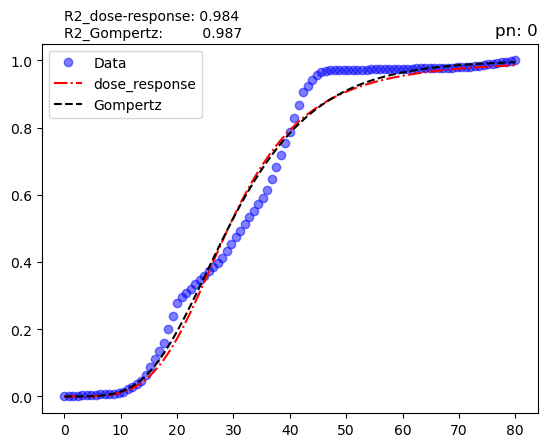

datapoint=  1
no=  2
The optimized parameters for dose-response are: [  6.924 134.811]
The optimized parameters for Gompertz are: [ 28.651 123.304]


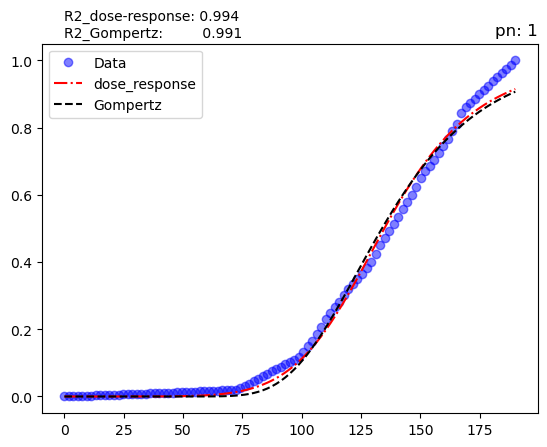

datapoint=  2
no=  3
The optimized parameters for dose-response are: [  9.623 149.749]
The optimized parameters for Gompertz are: [ 21.947 140.847]


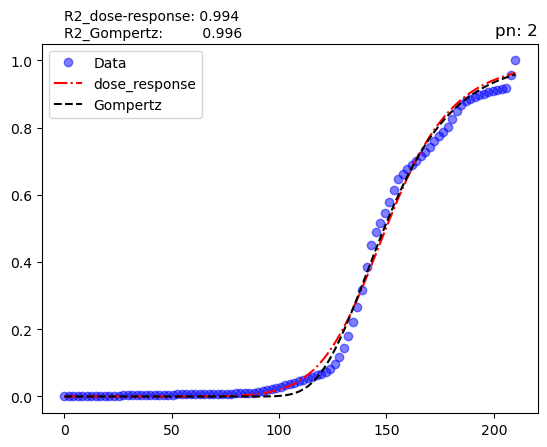

datapoint=  3
no=  4
The optimized parameters for dose-response are: [ 17.551 513.425]
The optimized parameters for Gompertz are: [ 42.379 494.556]


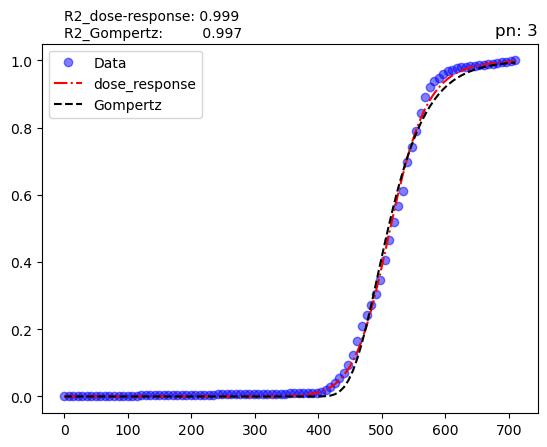

datapoint=  4
no=  5
The optimized parameters for dose-response are: [  8.284 268.698]
The optimized parameters for Gompertz are: [ 48.022 249.229]


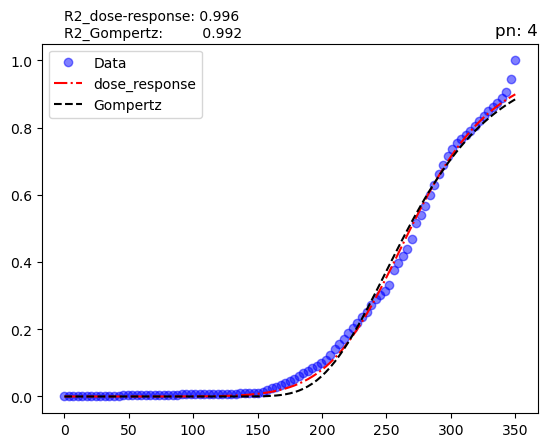

datapoint=  5
no=  6
The optimized parameters for dose-response are: [ 4.654 44.383]
The optimized parameters for Gompertz are: [13.983 39.326]


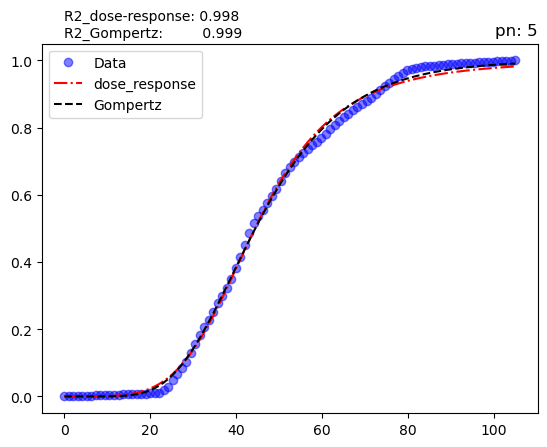

datapoint=  6
no=  7
The optimized parameters for dose-response are: [ 4.907 75.506]
The optimized parameters for Gompertz are: [22.317 67.147]


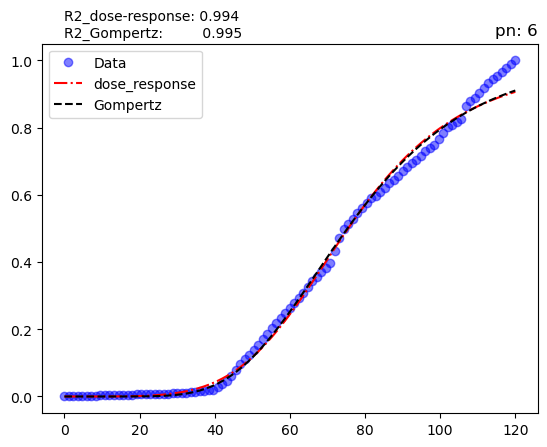

datapoint=  7
no=  8
The optimized parameters for dose-response are: [  9.774 115.878]
The optimized parameters for Gompertz are: [ 17.116 108.685]


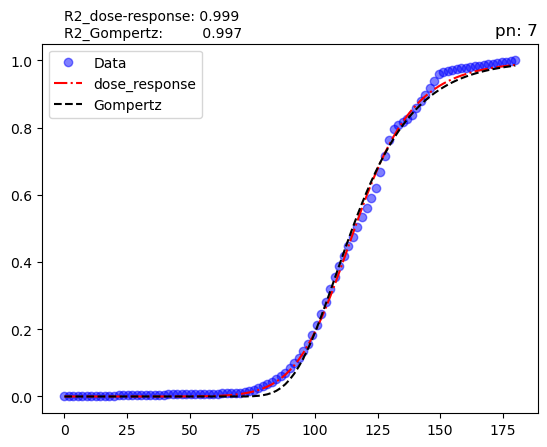

datapoint=  8
no=  9
The optimized parameters for dose-response are: [ 14.049 508.99 ]
The optimized parameters for Gompertz are: [ 51.36  487.361]


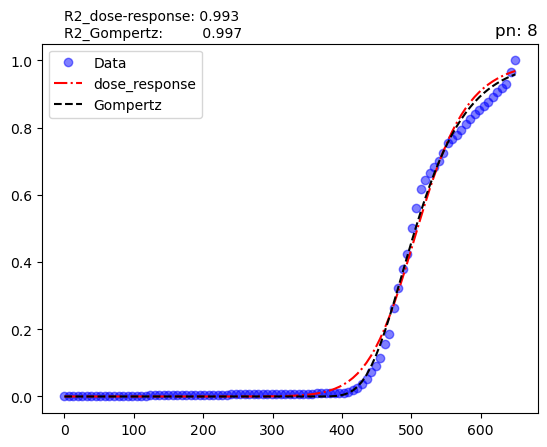

datapoint=  9
no=  10
The optimized parameters for dose-response are: [  7.408 317.827]
The optimized parameters for Gompertz are: [ 63.155 291.911]


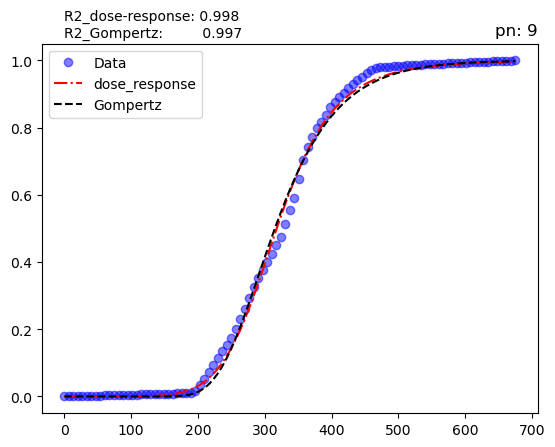

datapoint=  10
no=  11
The optimized parameters for dose-response are: [ 8.451 81.248]
The optimized parameters for Gompertz are: [13.895 75.537]


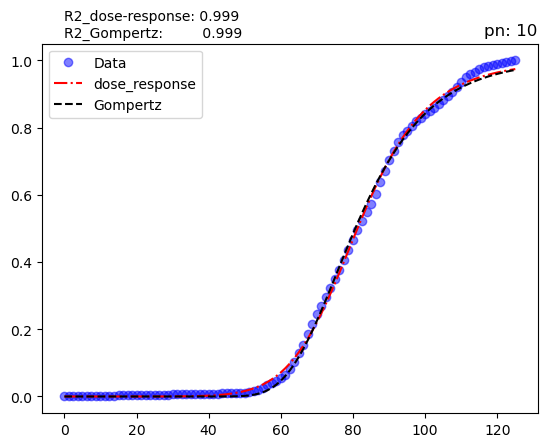

datapoint=  11
no=  12
The optimized parameters for dose-response are: [ 4.14 46.55]
The optimized parameters for Gompertz are: [16.5   40.786]


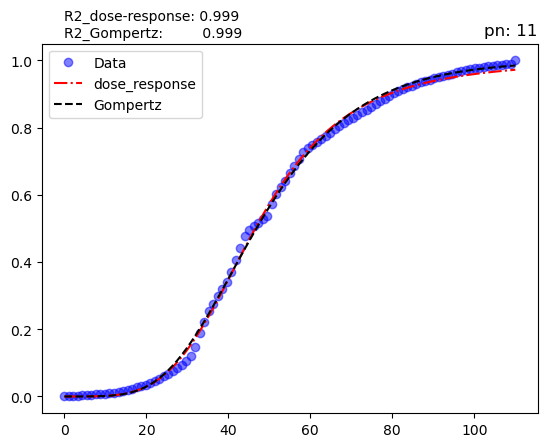

datapoint=  12
no=  13
The optimized parameters for dose-response are: [ 8.366 93.611]
The optimized parameters for Gompertz are: [16.152 86.921]


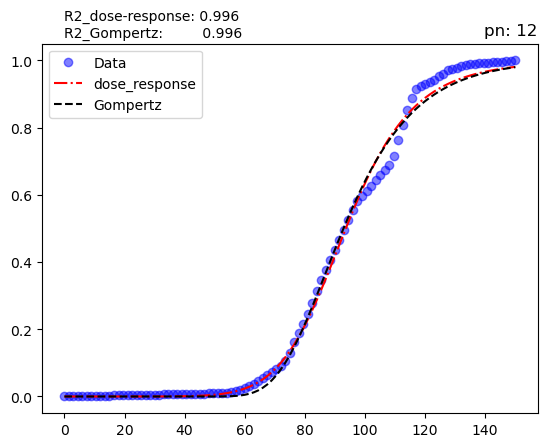

datapoint=  13
no=  14
The optimized parameters for dose-response are: [ 11.617 341.172]
The optimized parameters for Gompertz are: [ 42.168 323.323]


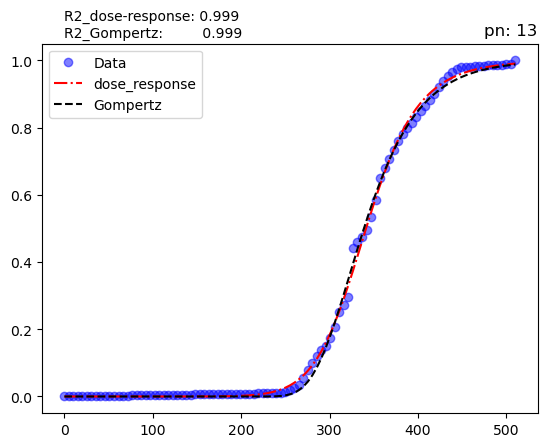

datapoint=  14
no=  15
The optimized parameters for dose-response are: [  8.284 268.698]
The optimized parameters for Gompertz are: [ 48.022 249.229]


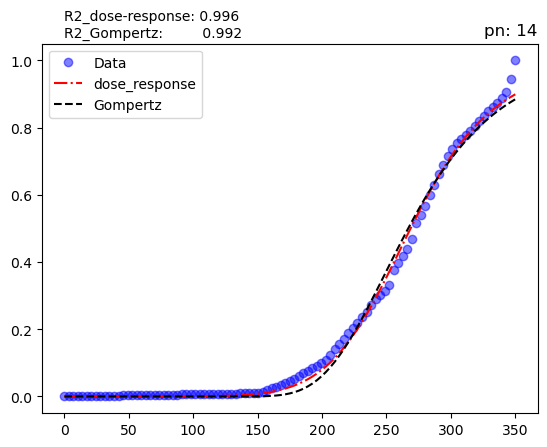

datapoint=  15
no=  16
The optimized parameters for dose-response are: [ 18.799 511.468]
The optimized parameters for Gompertz are: [ 39.13 494.09]


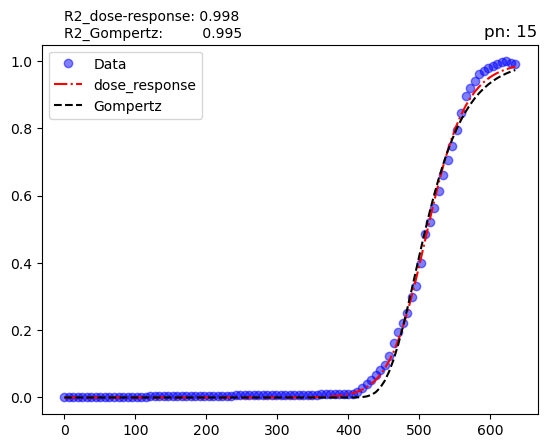

datapoint=  16
no=  17
The optimized parameters for dose-response are: [   7.451 1051.357]
The optimized parameters for Gompertz are: [206.324 966.373]


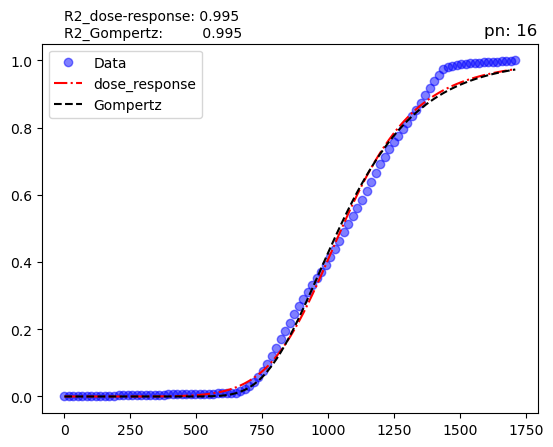

datapoint=  17
no=  18
The optimized parameters for dose-response are: [   8.175 1103.705]
The optimized parameters for Gompertz are: [ 195.834 1023.11 ]


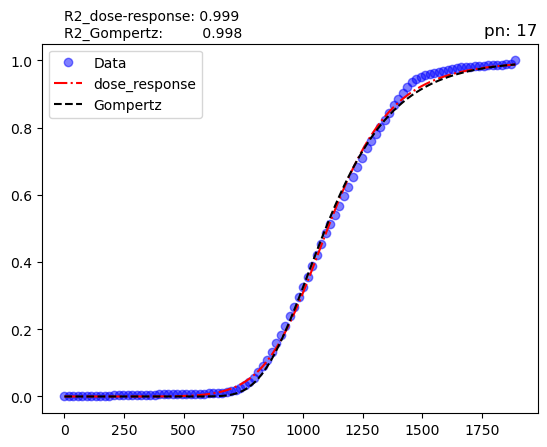

datapoint=  18
no=  27
The optimized parameters for dose-response are: [ 4.392 67.977]
The optimized parameters for Gompertz are: [23.399 59.367]


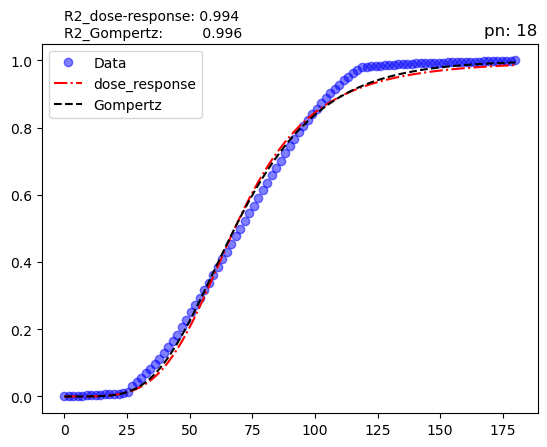

datapoint=  19
no=  28
The optimized parameters for dose-response are: [  3.857 121.939]
The optimized parameters for Gompertz are: [ 47.479 104.629]


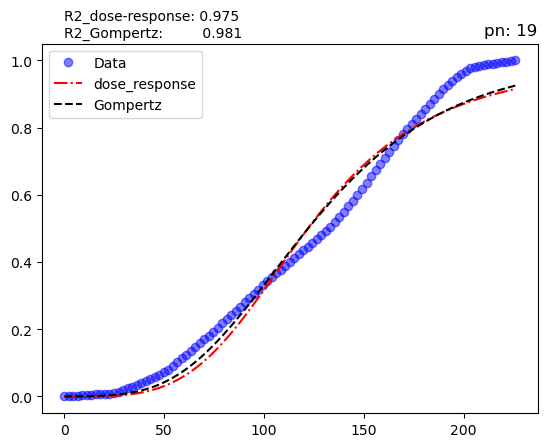

datapoint=  20
no=  29
The optimized parameters for dose-response are: [  4.296 148.839]
The optimized parameters for Gompertz are: [ 51.636 130.433]


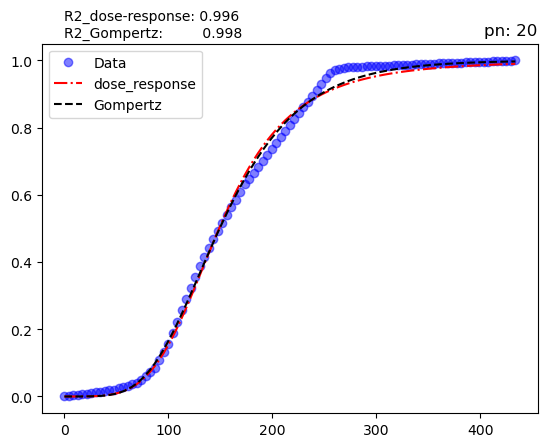

datapoint=  21
no=  30
The optimized parameters for dose-response are: [  3.636 368.047]
The optimized parameters for Gompertz are: [156.755 309.916]


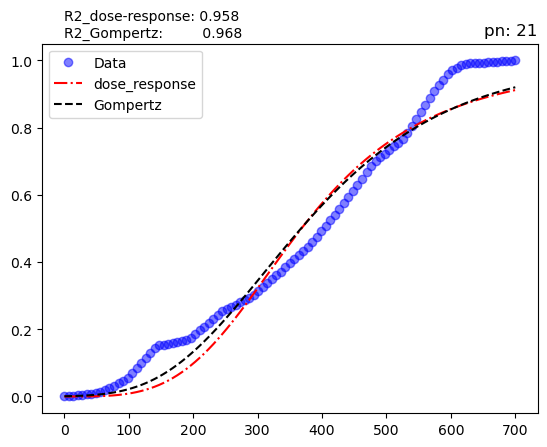

datapoint=  22
no=  31
The optimized parameters for dose-response are: [  3.226 211.416]
The optimized parameters for Gompertz are: [ 98.829 179.26 ]


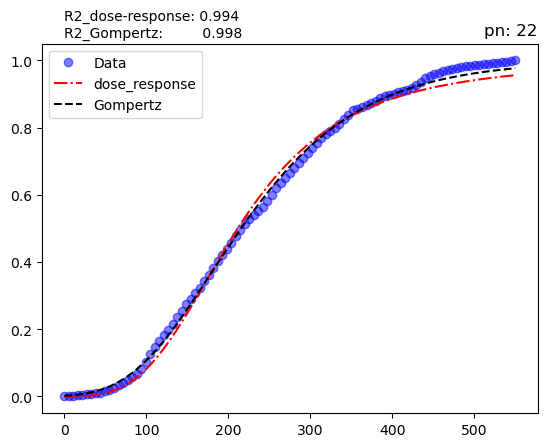

datapoint=  23
no=  32
The optimized parameters for dose-response are: [ 8.077 14.048]
The optimized parameters for Gompertz are: [ 2.53  12.995]


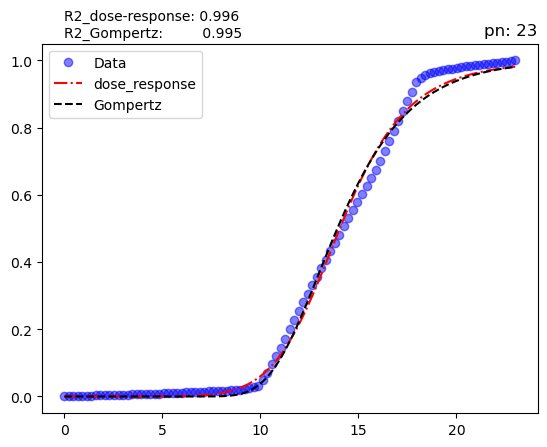

datapoint=  24
no=  33
The optimized parameters for dose-response are: [ 4.877 25.938]
The optimized parameters for Gompertz are: [ 7.803 23.046]


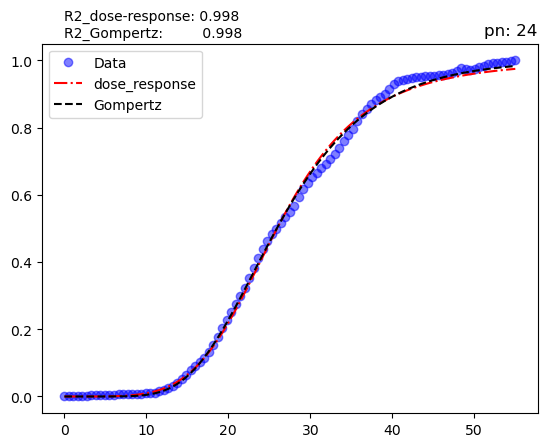

datapoint=  25
no=  34
The optimized parameters for dose-response are: [  8.126 113.3  ]
The optimized parameters for Gompertz are: [ 20.394 104.825]


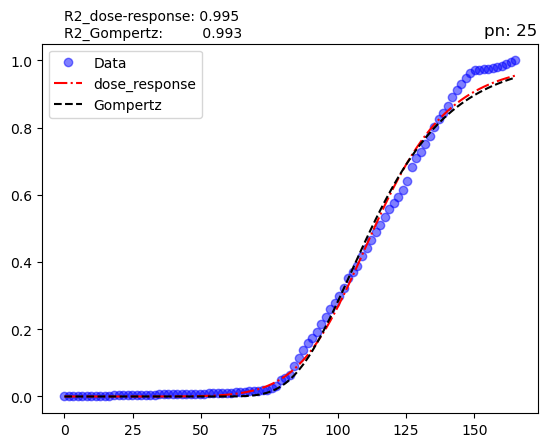

datapoint=  26
no=  35
The optimized parameters for dose-response are: [  6.328 110.597]
The optimized parameters for Gompertz are: [ 25.513 100.539]


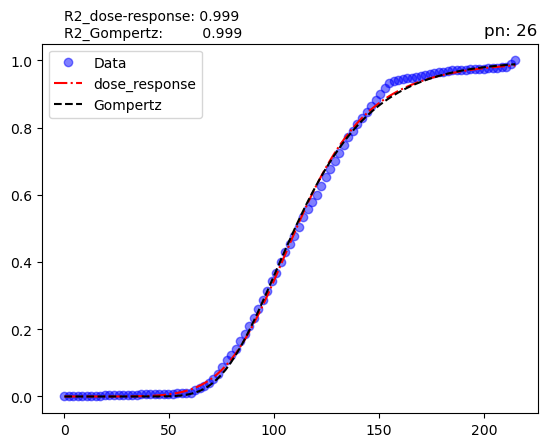

datapoint=  27
no=  36
The optimized parameters for dose-response are: [   7.962 1106.054]
The optimized parameters for Gompertz are: [ 201.264 1023.789]


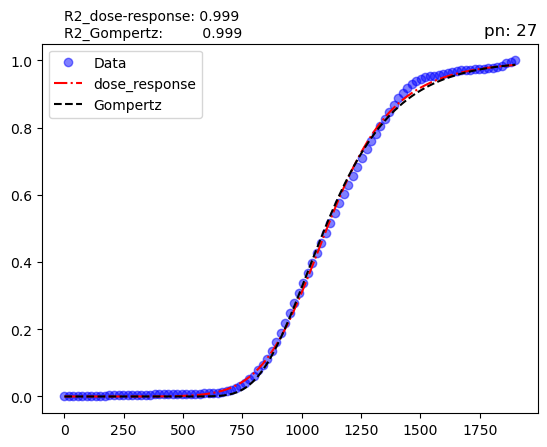

datapoint=  28
no=  37
The optimized parameters for dose-response are: [6.423 9.618]
The optimized parameters for Gompertz are: [2.164 8.771]


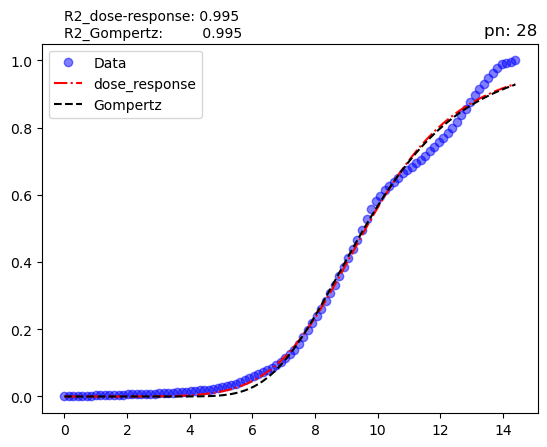

datapoint=  29
no=  38
The optimized parameters for dose-response are: [ 4.957 22.097]
The optimized parameters for Gompertz are: [ 6.809 19.417]


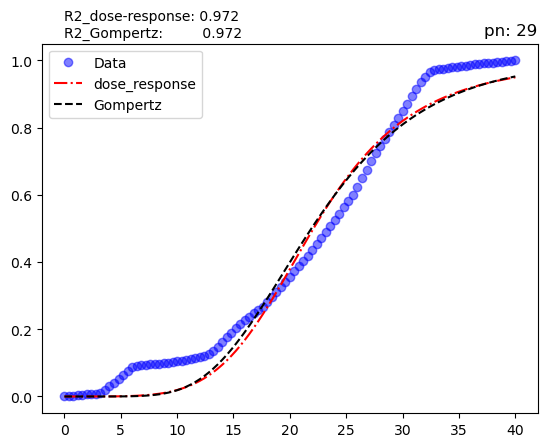

datapoint=  30
no=  39
The optimized parameters for dose-response are: [ 5.225 53.073]
The optimized parameters for Gompertz are: [14.819 47.436]


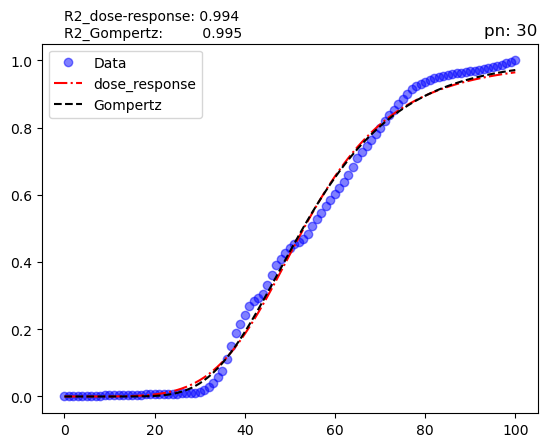

datapoint=  31
no=  40
The optimized parameters for dose-response are: [ 4.795 94.183]
The optimized parameters for Gompertz are: [28.392 83.571]


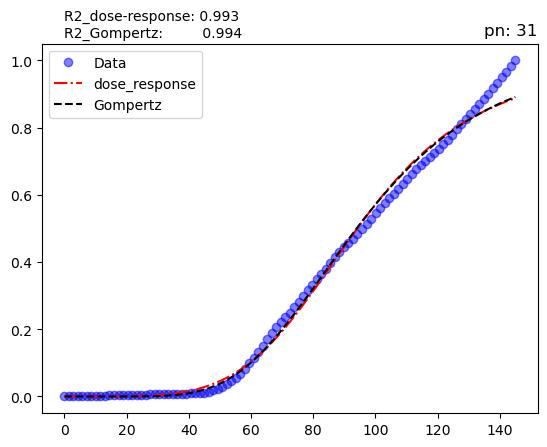

datapoint=  32
no=  41
The optimized parameters for dose-response are: [   6.172 1008.876]
The optimized parameters for Gompertz are: [240.66  913.364]


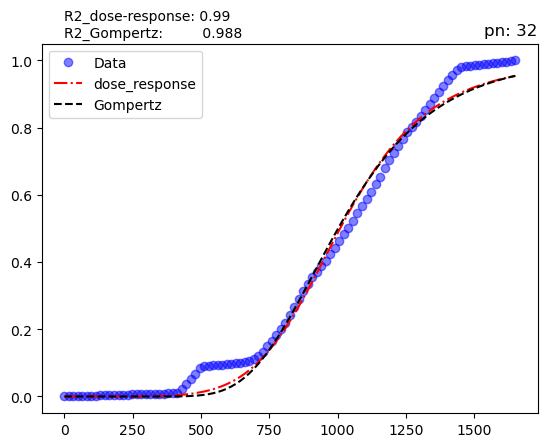

datapoint=  33
no=  42
The optimized parameters for dose-response are: [ 3.989 45.841]
The optimized parameters for Gompertz are: [16.106 40.381]


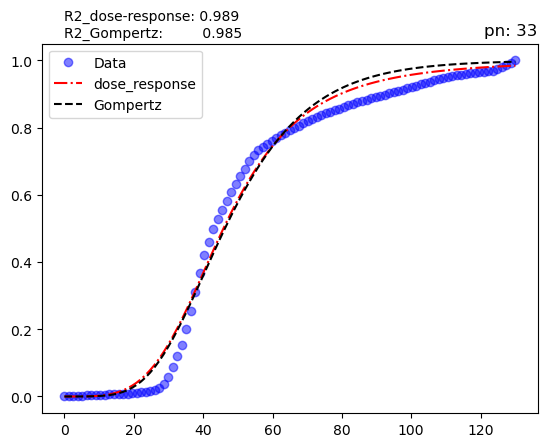

datapoint=  34
no=  43
The optimized parameters for dose-response are: [ 6.436 69.071]
The optimized parameters for Gompertz are: [15.096 63.296]


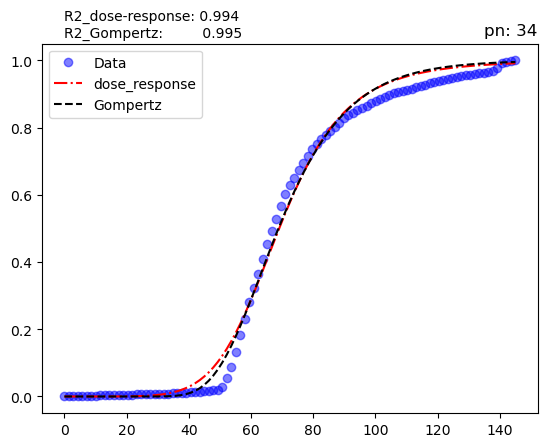

datapoint=  35
no=  44
The optimized parameters for dose-response are: [10.957 91.067]
The optimized parameters for Gompertz are: [11.746 86.225]


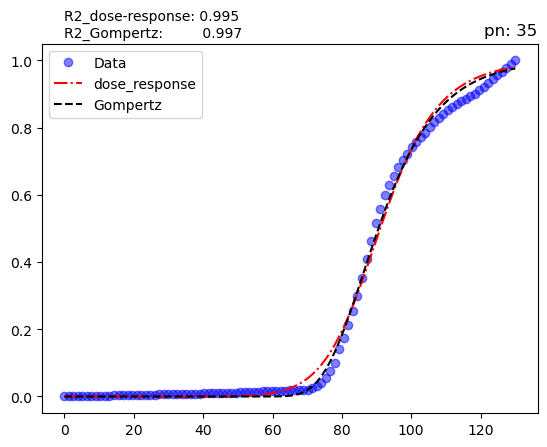

datapoint=  36
no=  45
The optimized parameters for dose-response are: [ 19.076 112.039]
The optimized parameters for Gompertz are: [  8.41  108.455]


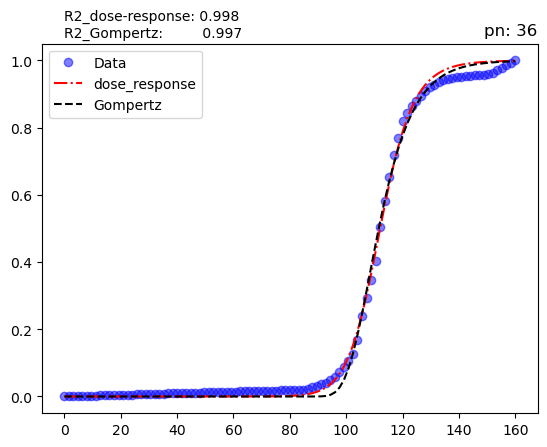

datapoint=  37
no=  46
The optimized parameters for dose-response are: [ 13.103 447.178]
The optimized parameters for Gompertz are: [ 48.623 426.686]


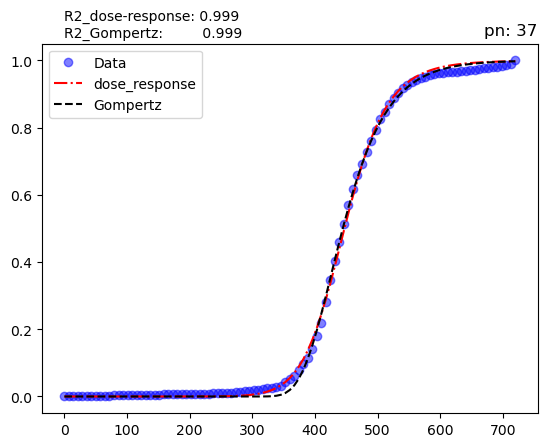

datapoint=  38
no=  47
The optimized parameters for dose-response are: [ 24.01  220.777]
The optimized parameters for Gompertz are: [ 13.326 214.835]


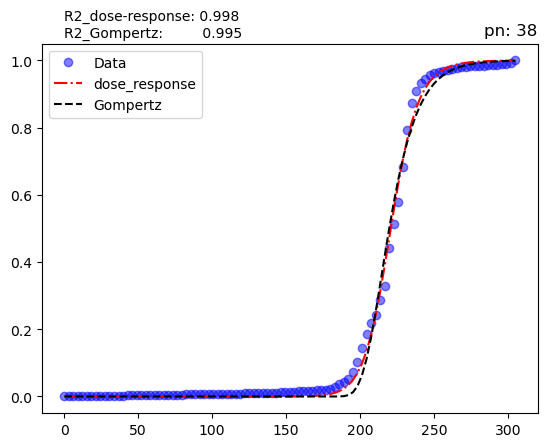

datapoint=  39
no=  48
The optimized parameters for dose-response are: [ 20.992 277.537]
The optimized parameters for Gompertz are: [ 18.852 269.285]


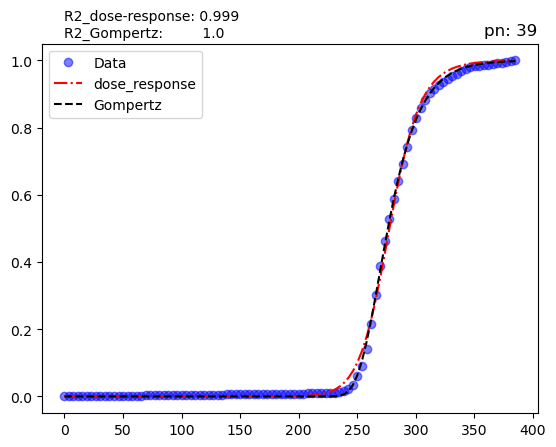

datapoint=  40
no=  49
The optimized parameters for dose-response are: [ 23.237 385.056]
The optimized parameters for Gompertz are: [ 23.535 374.976]


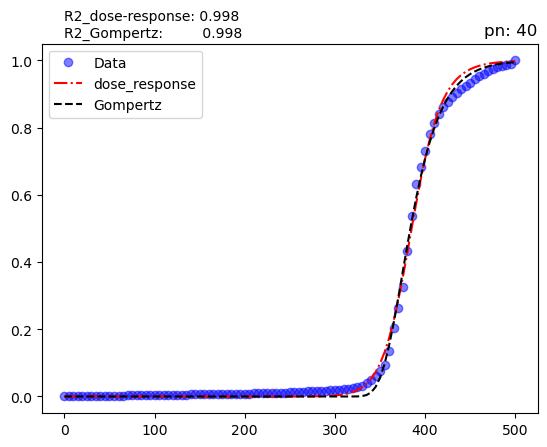

datapoint=  41
no=  50
The optimized parameters for dose-response are: [ 15.42  459.657]
The optimized parameters for Gompertz are: [ 42.878 440.898]


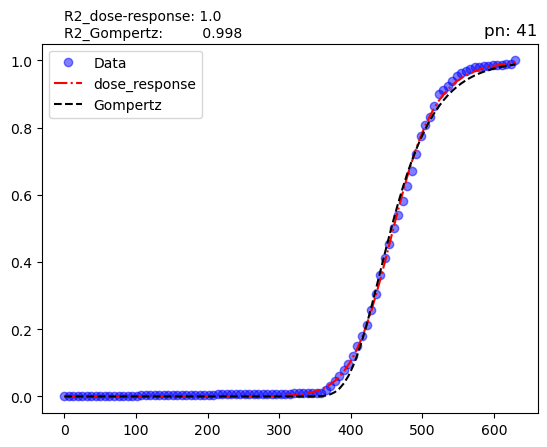

datapoint=  42
no=  51
The optimized parameters for dose-response are: [ 15.616 481.45 ]
The optimized parameters for Gompertz are: [ 44.146 462.47 ]


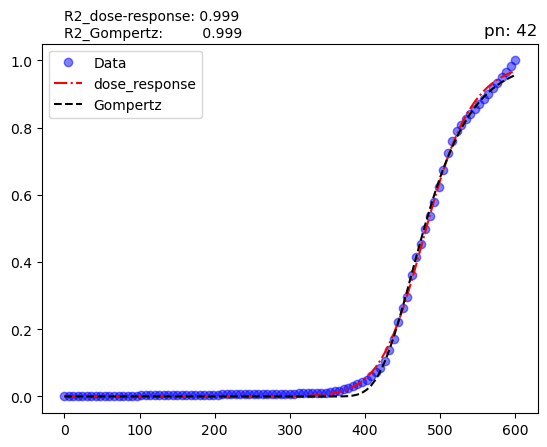

datapoint=  43
no=  52
The optimized parameters for dose-response are: [44.64  88.551]
The optimized parameters for Gompertz are: [ 2.648 87.462]


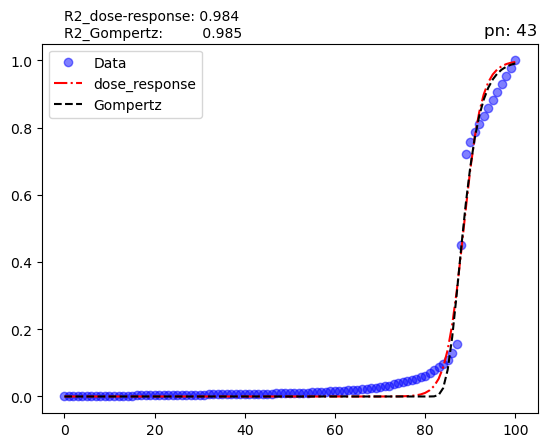

datapoint=  44
no=  53
The optimized parameters for dose-response are: [ 24.386 112.814]
The optimized parameters for Gompertz are: [  6.487 109.989]


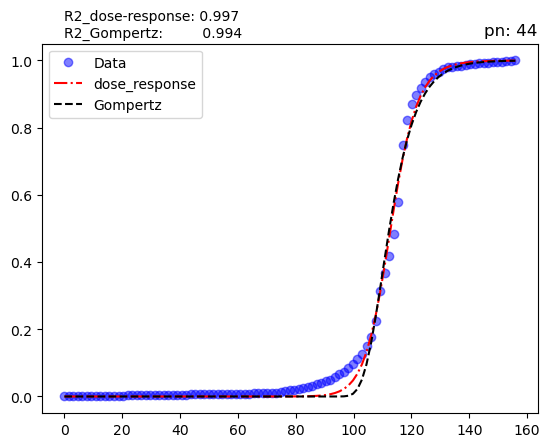

datapoint=  45
no=  54
The optimized parameters for dose-response are: [ 21.1   189.875]
The optimized parameters for Gompertz are: [ 12.969 184.269]


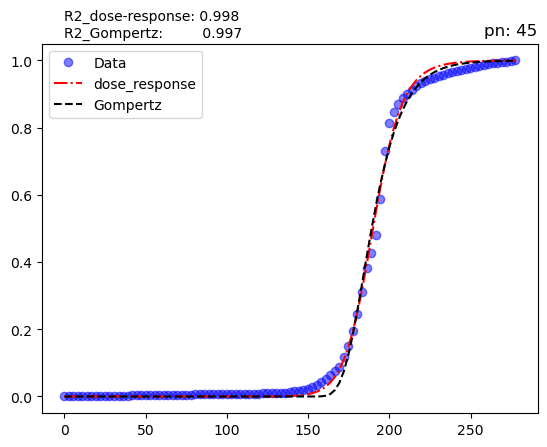

datapoint=  46
no=  55
The optimized parameters for dose-response are: [ 31.62  236.107]
The optimized parameters for Gompertz are: [ 10.799 231.393]


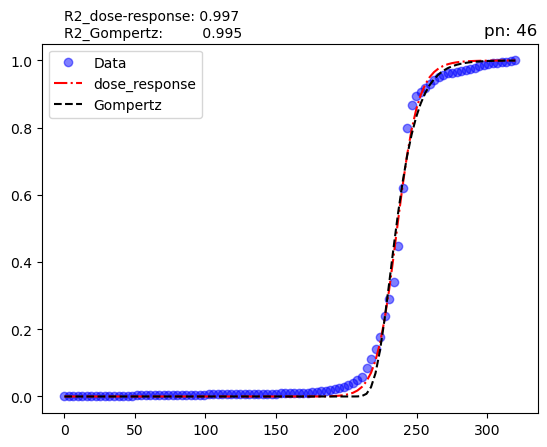

datapoint=  47
no=  56
The optimized parameters for dose-response are: [1.577 0.966]
The optimized parameters for Gompertz are: [0.912 0.769]


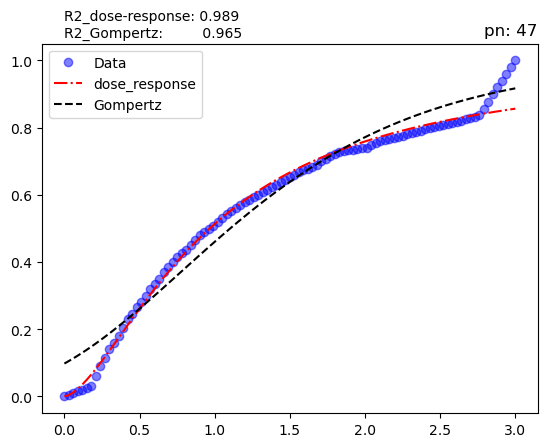

datapoint=  48
no=  57
The optimized parameters for dose-response are: [1.266 0.07 ]
The optimized parameters for Gompertz are: [0.104 0.053]


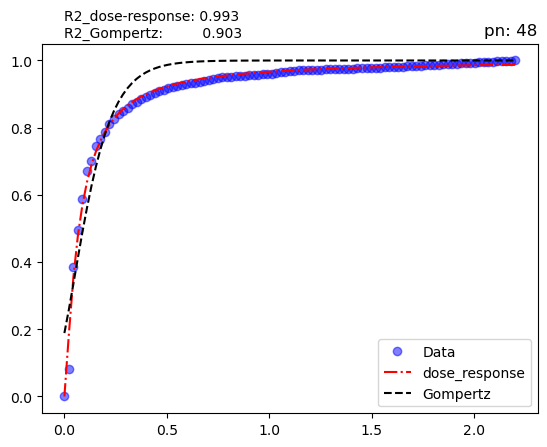

datapoint=  49
no=  58
The optimized parameters for dose-response are: [1.307 0.058]
The optimized parameters for Gompertz are: [0.064 0.048]


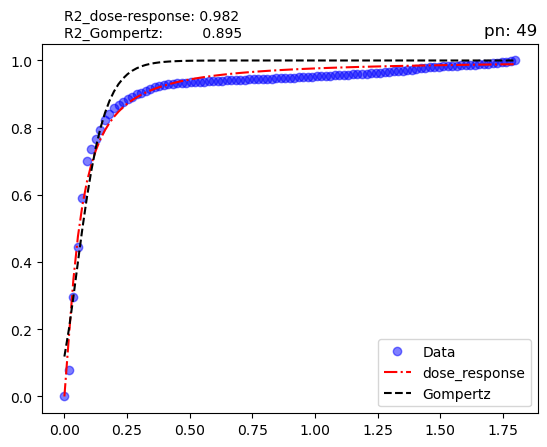

datapoint=  50
no=  59
The optimized parameters for dose-response are: [1.046 0.202]
The optimized parameters for Gompertz are: [0.496 0.083]


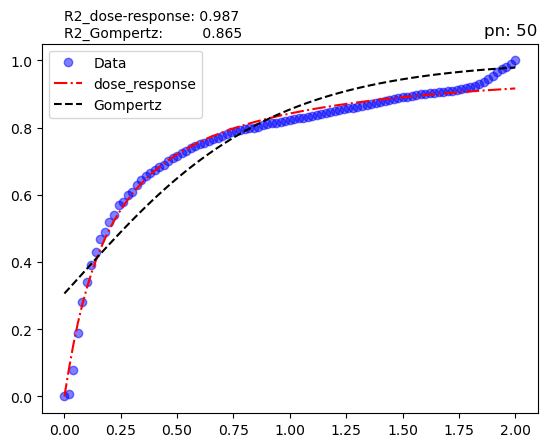

datapoint=  51
no=  60
The optimized parameters for dose-response are: [8.158 3.622]
The optimized parameters for Gompertz are: [0.632 3.373]


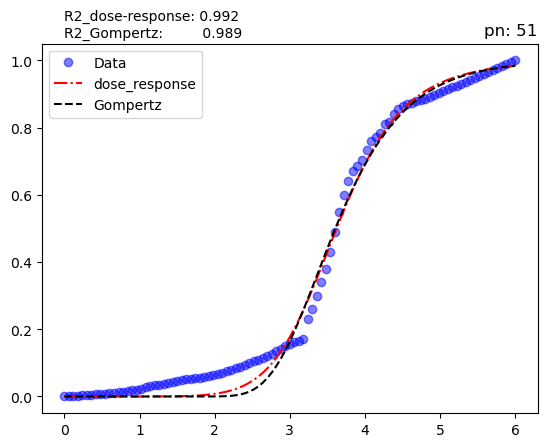

datapoint=  52
no=  61
The optimized parameters for dose-response are: [2.929 1.059]
The optimized parameters for Gompertz are: [0.577 0.874]


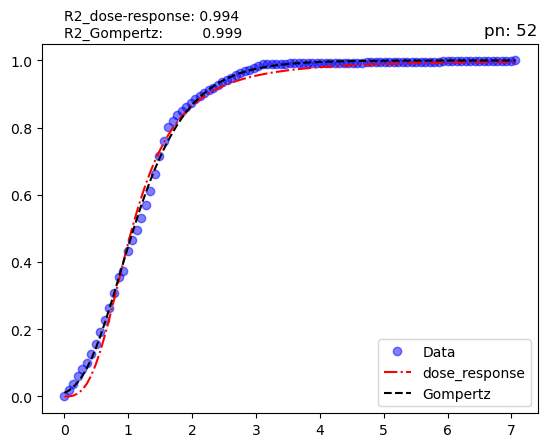

datapoint=  53
no=  62
The optimized parameters for dose-response are: [2.523 0.942]
The optimized parameters for Gompertz are: [0.609 0.763]


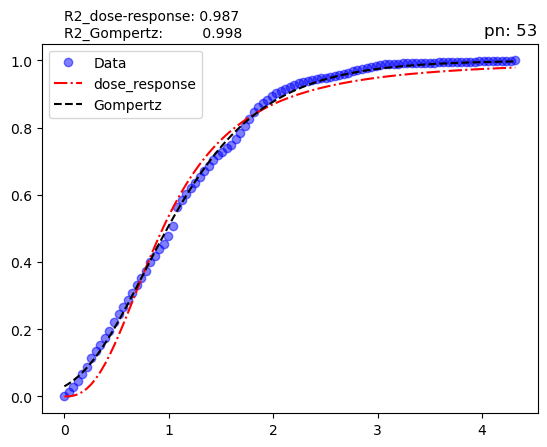

datapoint=  54
no=  63
The optimized parameters for dose-response are: [3.839 1.999]
The optimized parameters for Gompertz are: [0.743 1.733]


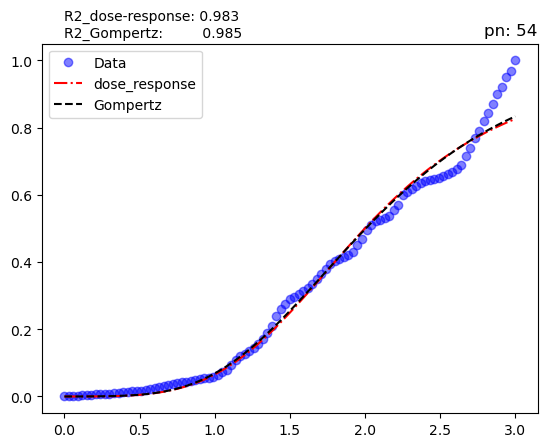

datapoint=  55
no=  64
The optimized parameters for dose-response are: [ 19.169 204.829]
The optimized parameters for Gompertz are: [ 15.284 198.132]


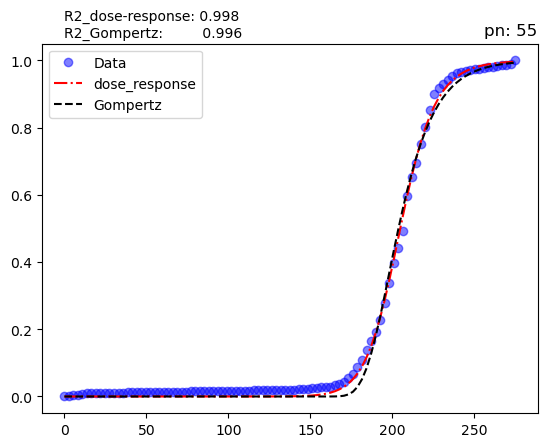

datapoint=  56
no=  65
The optimized parameters for dose-response are: [ 18.325 273.89 ]
The optimized parameters for Gompertz are: [ 21.05  264.837]


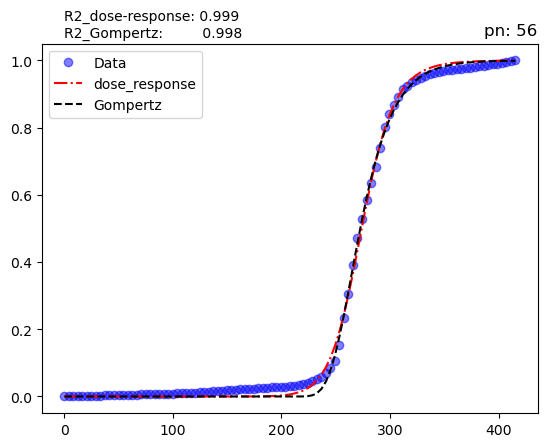

datapoint=  57
no=  66
The optimized parameters for dose-response are: [ 23.578 355.446]
The optimized parameters for Gompertz are: [ 21.164 346.323]


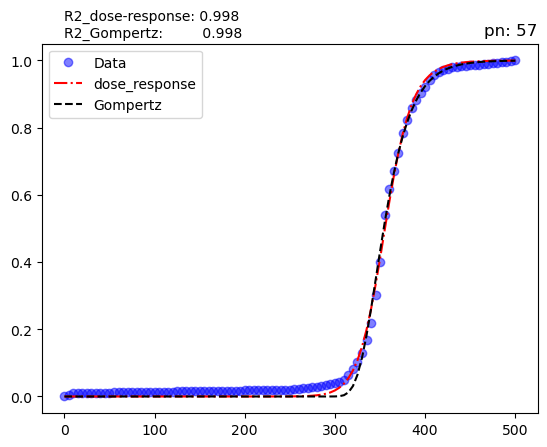

datapoint=  58
no=  67
The optimized parameters for dose-response are: [ 14.66  438.044]
The optimized parameters for Gompertz are: [ 43.325 419.565]


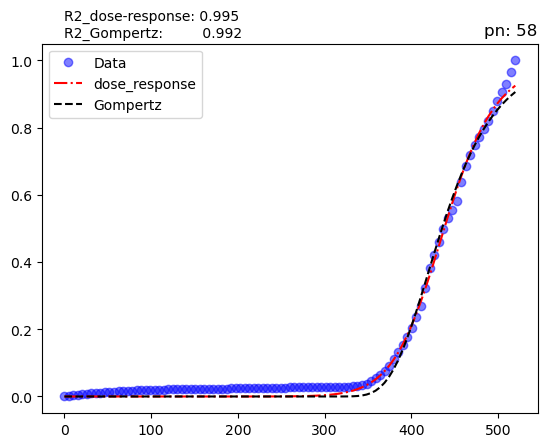

datapoint=  59
no=  68
The optimized parameters for dose-response are: [ 14.746 492.087]
The optimized parameters for Gompertz are: [ 47.558 471.878]


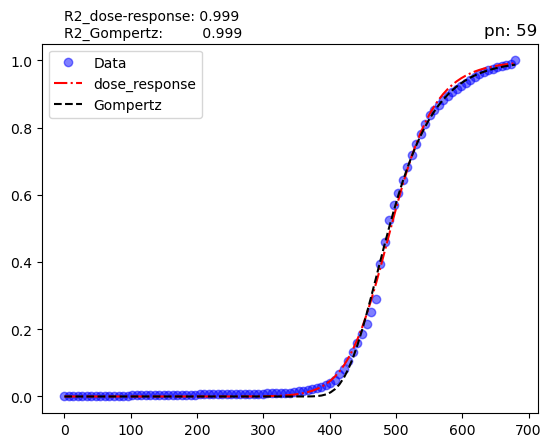

datapoint=  60
no=  69
The optimized parameters for dose-response are: [ 4.482 37.001]
The optimized parameters for Gompertz are: [11.776 32.87 ]


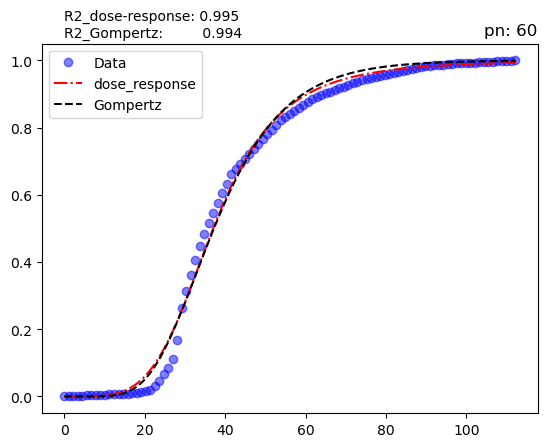

datapoint=  61
no=  70
The optimized parameters for dose-response are: [10.059 91.466]
The optimized parameters for Gompertz are: [12.733 86.306]


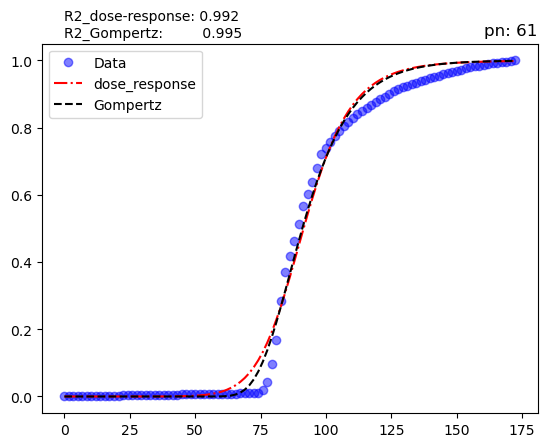

datapoint=  62
no=  71
The optimized parameters for dose-response are: [ 13.383 138.696]
The optimized parameters for Gompertz are: [ 14.639 132.605]


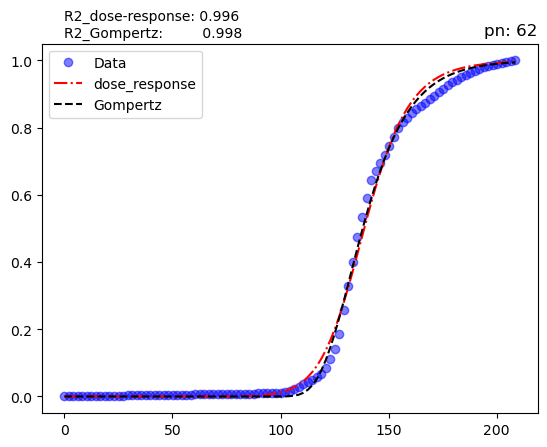

datapoint=  63
no=  72
The optimized parameters for dose-response are: [7.092 0.371]
The optimized parameters for Gompertz are: [0.076 0.341]


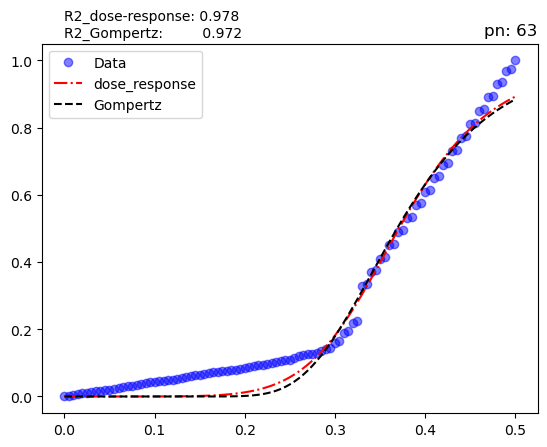

datapoint=  64
no=  73
The optimized parameters for dose-response are: [6.6   4.678]
The optimized parameters for Gompertz are: [1.104 4.244]


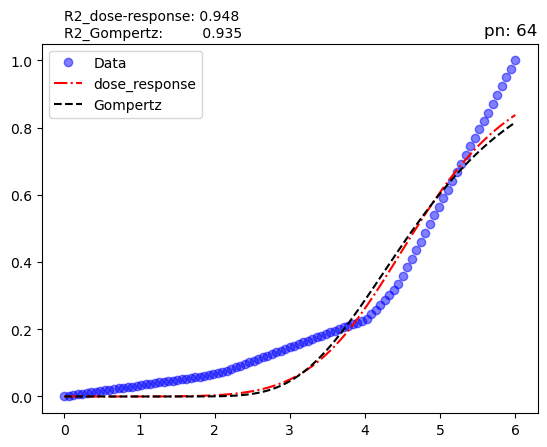

datapoint=  65
no=  74
The optimized parameters for dose-response are: [17.634 18.396]
The optimized parameters for Gompertz are: [ 1.392 17.857]


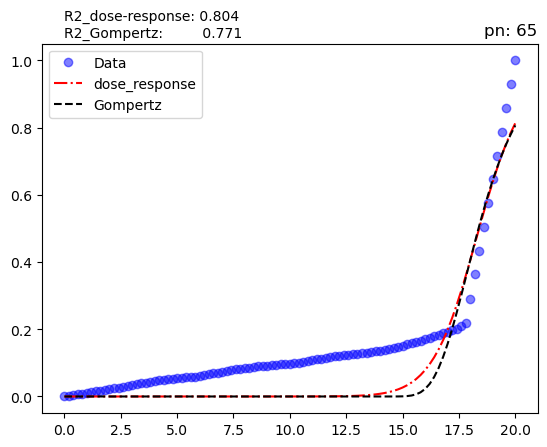

datapoint=  66
no=  76
The optimized parameters for dose-response are: [5.031 0.232]
The optimized parameters for Gompertz are: [0.082 0.203]


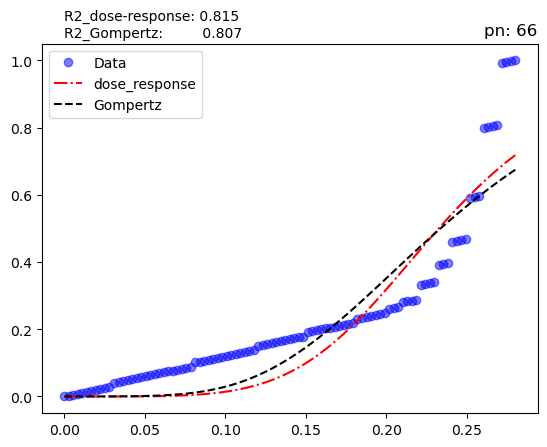

datapoint=  67
no=  108
The optimized parameters for dose-response are: [ 1.599 38.694]
The optimized parameters for Gompertz are: [44.668 30.095]


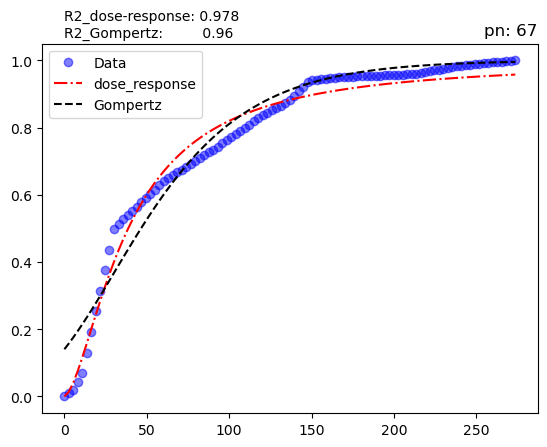

datapoint=  68
no=  110
The optimized parameters for dose-response are: [11.693 87.569]
The optimized parameters for Gompertz are: [13.08  83.137]


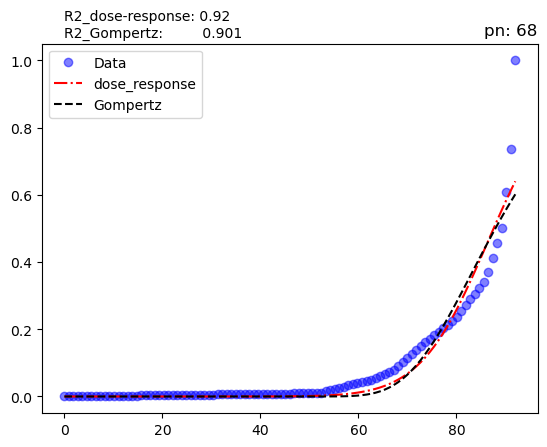

datapoint=  69
no=  136
The optimized parameters for dose-response are: [  7.598 144.242]
The optimized parameters for Gompertz are: [ 27.646 133.075]


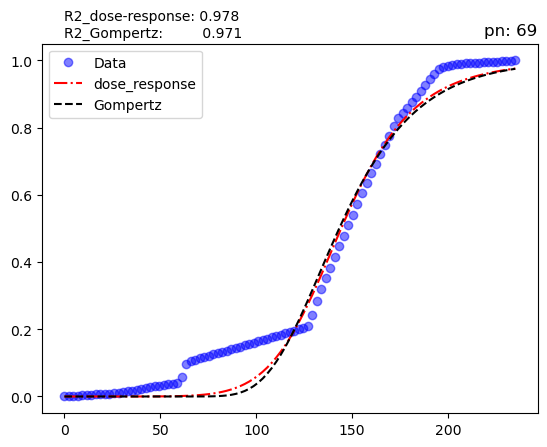

datapoint=  70
no=  137
The optimized parameters for dose-response are: [ 3.878 43.131]
The optimized parameters for Gompertz are: [16.055 37.752]


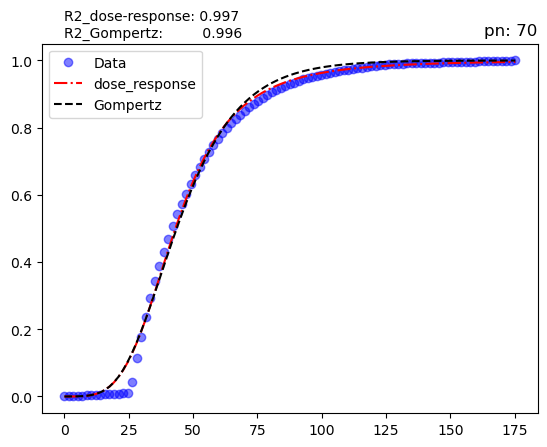

datapoint=  71
no=  138
The optimized parameters for dose-response are: [ 3.3   54.563]
The optimized parameters for Gompertz are: [21.248 47.501]


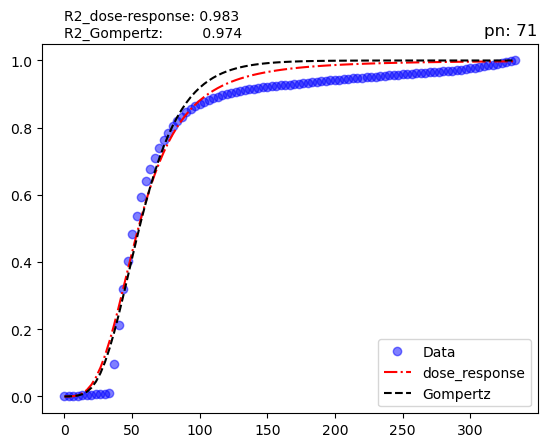

datapoint=  72
no=  139
The optimized parameters for dose-response are: [2.75  0.164]
The optimized parameters for Gompertz are: [0.098 0.132]


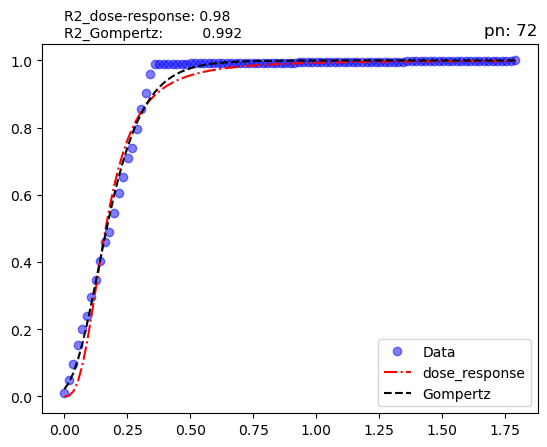

datapoint=  73
no=  140
The optimized parameters for dose-response are: [ 4.52  50.869]
The optimized parameters for Gompertz are: [16.204 45.105]


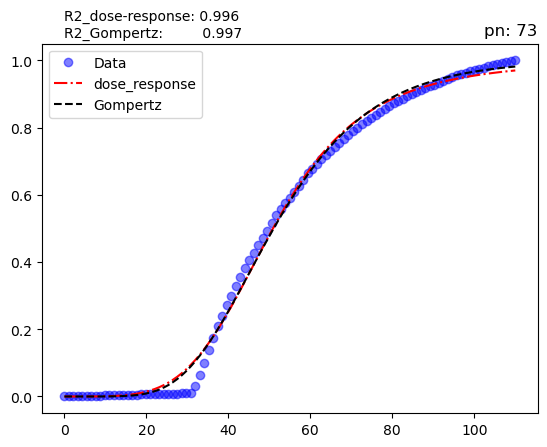

datapoint=  74
no=  141
The optimized parameters for dose-response are: [ 1.723 16.61 ]
The optimized parameters for Gompertz are: [15.946 12.811]


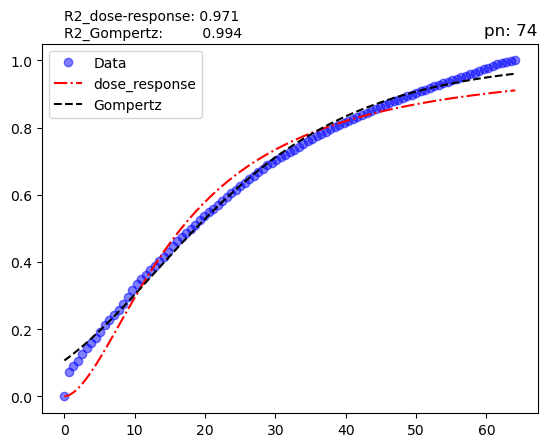

datapoint=  75
no=  19
The optimized parameters for dose-response are: [ 1.921 51.779]
The optimized parameters for Gompertz are: [44.491 41.359]


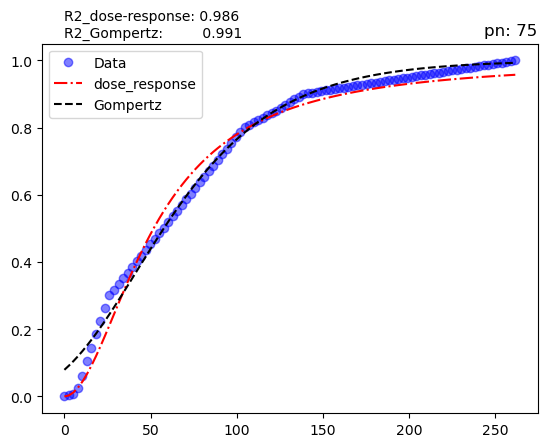

datapoint=  76
no=  20
The optimized parameters for dose-response are: [ 2.642 35.945]
The optimized parameters for Gompertz are: [20.755 29.994]


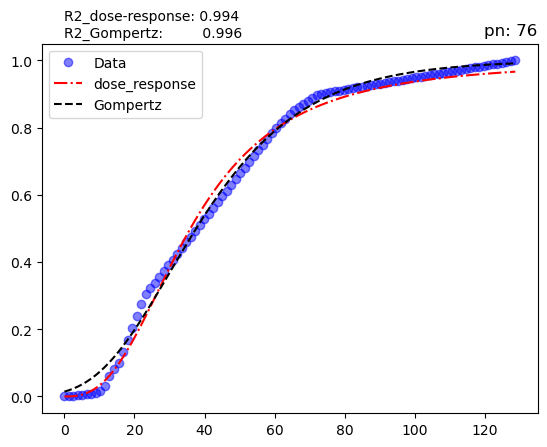

datapoint=  77
no=  21
The optimized parameters for dose-response are: [ 5.444 14.094]
The optimized parameters for Gompertz are: [ 3.838 12.609]


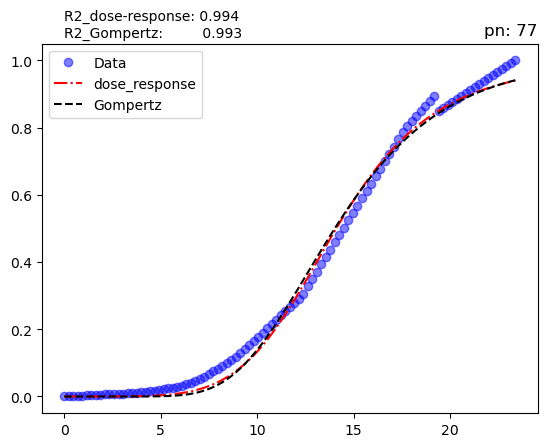

datapoint=  78
no=  22
The optimized parameters for dose-response are: [  8.322 129.68 ]
The optimized parameters for Gompertz are: [ 22.584 120.366]


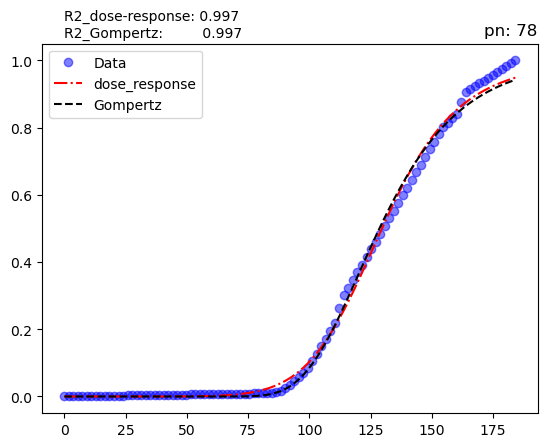

datapoint=  79
no=  23
The optimized parameters for dose-response are: [ 3.845 49.694]
The optimized parameters for Gompertz are: [18.663 43.41 ]


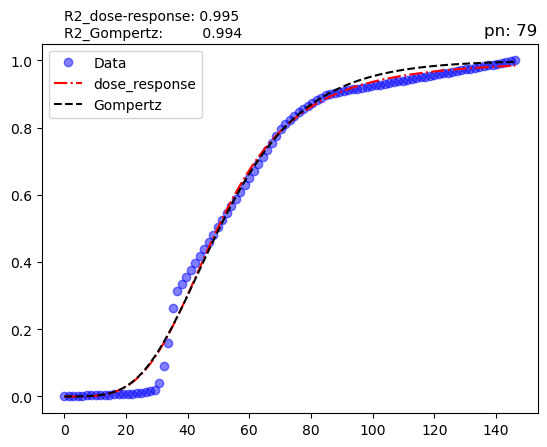

datapoint=  80
no=  24
The optimized parameters for dose-response are: [ 3.54 62.44]
The optimized parameters for Gompertz are: [25.777 54.045]


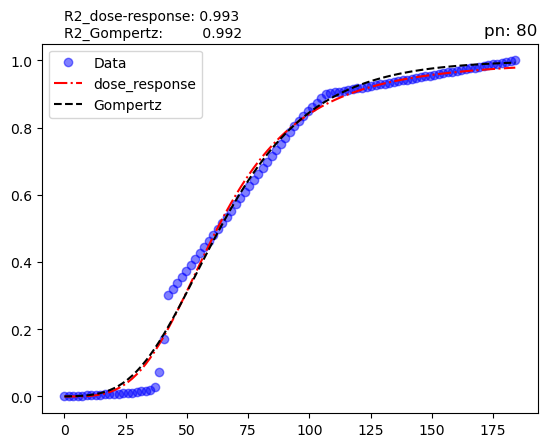

datapoint=  81
no=  25
The optimized parameters for dose-response are: [ 14.254 185.863]
The optimized parameters for Gompertz are: [ 18.752 178.007]


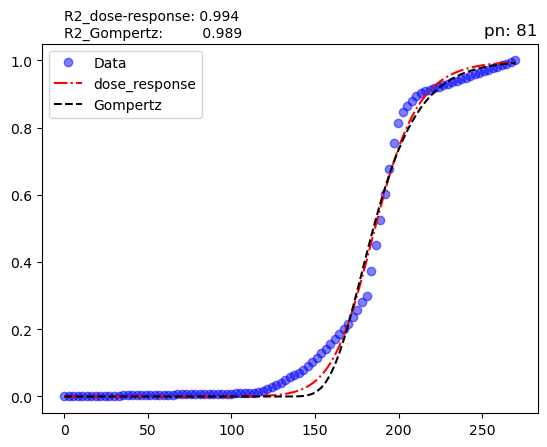

datapoint=  82
no=  26
The optimized parameters for dose-response are: [ 22.36  192.476]
The optimized parameters for Gompertz are: [ 12.283 187.381]


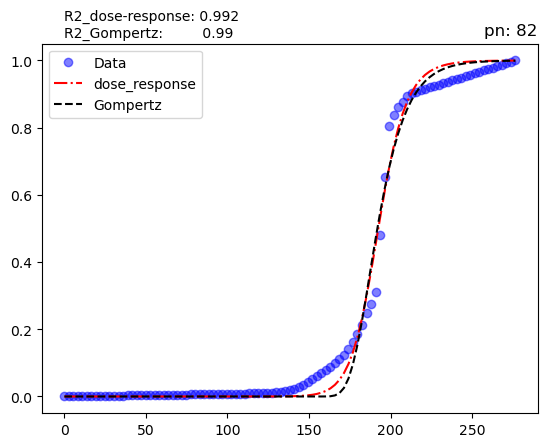

datapoint=  83
no=  75
The optimized parameters for dose-response are: [1.724 0.209]
The optimized parameters for Gompertz are: [0.182 0.169]


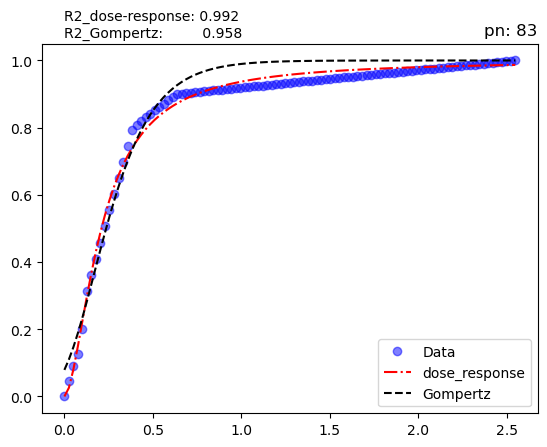

datapoint=  84
no=  77
The optimized parameters for dose-response are: [7.875 4.756]
The optimized parameters for Gompertz are: [0.928 4.365]


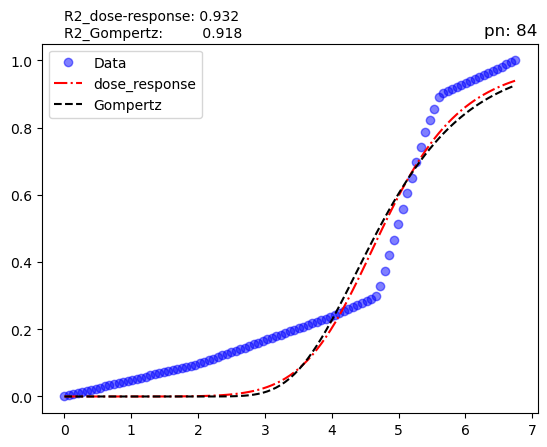

datapoint=  85
no=  78
The optimized parameters for dose-response are: [ 8.358 19.681]
The optimized parameters for Gompertz are: [ 4.228 18.293]


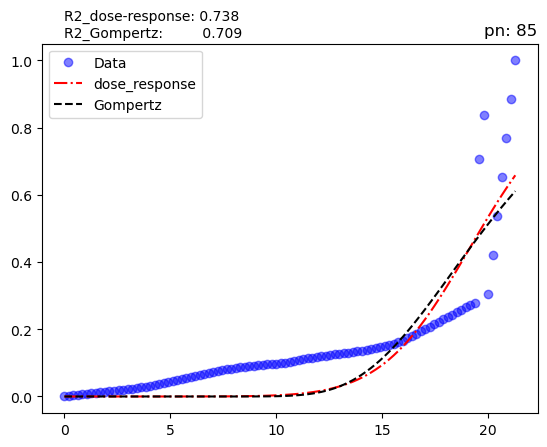

datapoint=  86
no=  79
The optimized parameters for dose-response are: [11.624 18.312]
The optimized parameters for Gompertz are: [ 2.391 17.334]


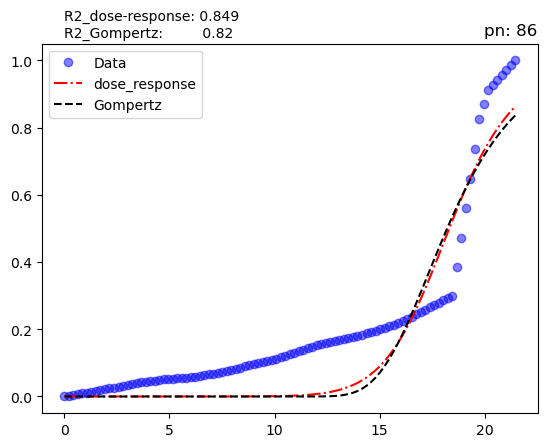

datapoint=  87
no=  80
The optimized parameters for dose-response are: [ 4.666 21.599]
The optimized parameters for Gompertz are: [ 7.208 18.774]


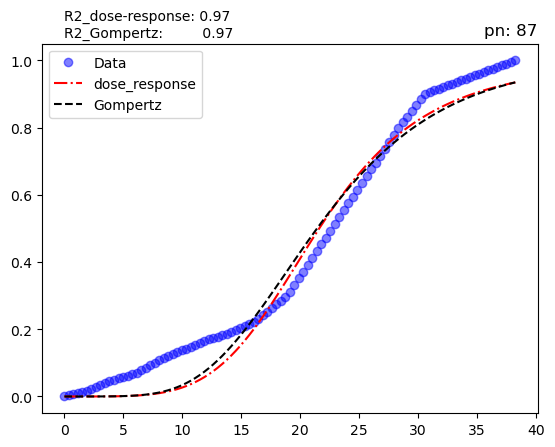

datapoint=  88
no=  81
The optimized parameters for dose-response are: [ 4.306 21.047]
The optimized parameters for Gompertz are: [ 7.698 18.054]


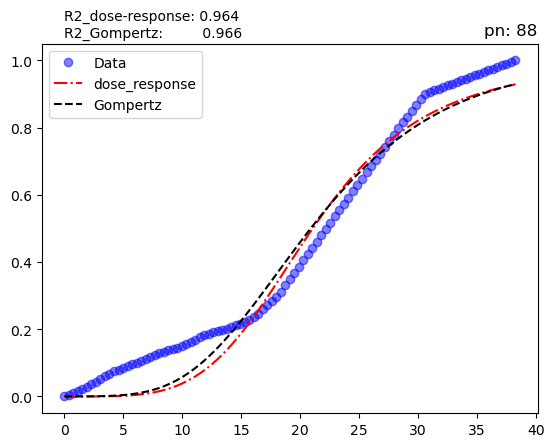

datapoint=  89
no=  82
The optimized parameters for dose-response are: [7.927 4.694]
The optimized parameters for Gompertz are: [0.901 4.316]


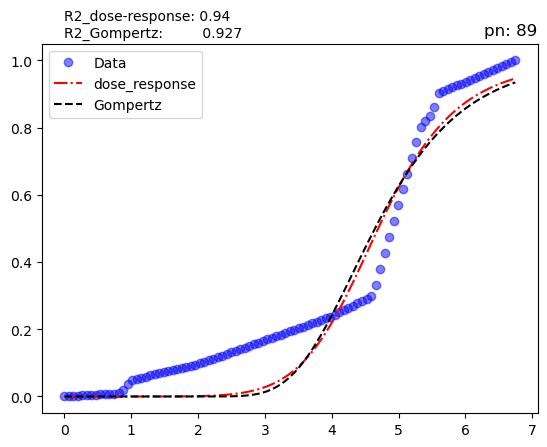

datapoint=  90
no=  83
The optimized parameters for dose-response are: [3.972 3.873]
The optimized parameters for Gompertz are: [1.501 3.308]


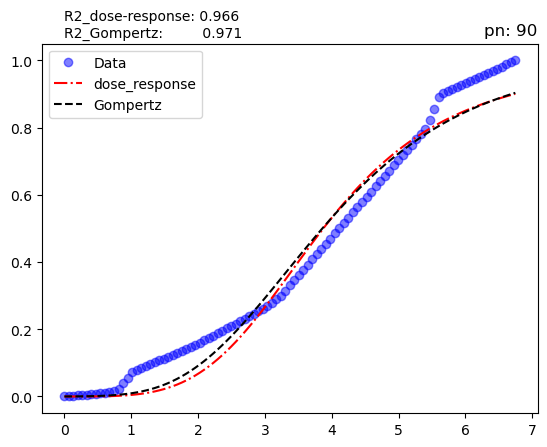

datapoint=  91
no=  84
The optimized parameters for dose-response are: [3.725 3.783]
The optimized parameters for Gompertz are: [1.556 3.208]


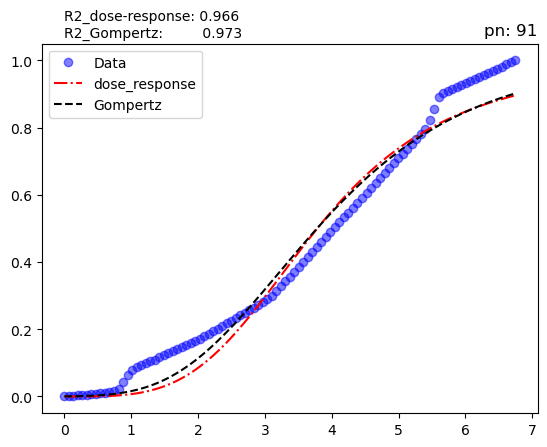

datapoint=  92
no=  85
The optimized parameters for dose-response are: [3.286 3.576]
The optimized parameters for Gompertz are: [1.643 2.998]


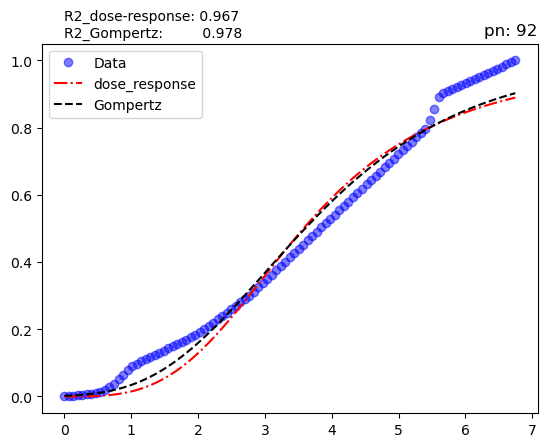

datapoint=  93
no=  86
The optimized parameters for dose-response are: [ 3.131 18.15 ]
The optimized parameters for Gompertz are: [ 8.792 15.158]


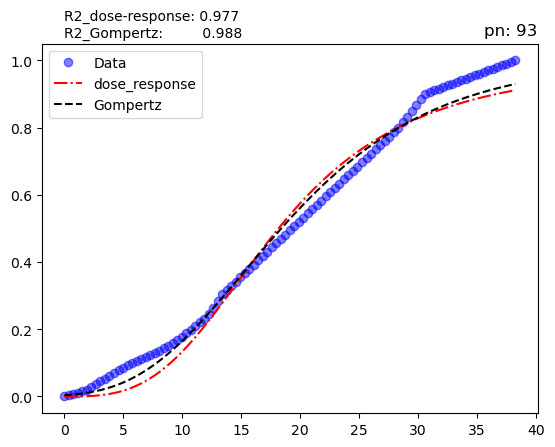

datapoint=  94
no=  87
The optimized parameters for dose-response are: [ 5.379 22.461]
The optimized parameters for Gompertz are: [ 6.378 19.938]


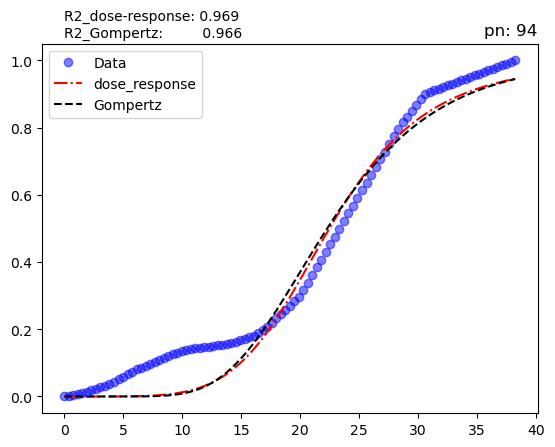

datapoint=  95
no=  88
The optimized parameters for dose-response are: [ 8.802 19.687]
The optimized parameters for Gompertz are: [ 3.939 18.367]


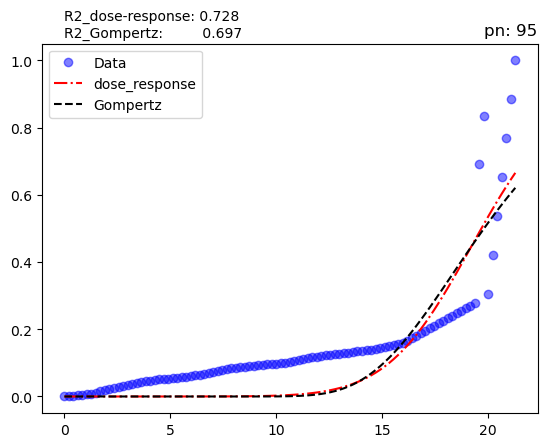

datapoint=  96
no=  89
The optimized parameters for dose-response are: [ 4.169 20.482]
The optimized parameters for Gompertz are: [ 7.525 17.663]


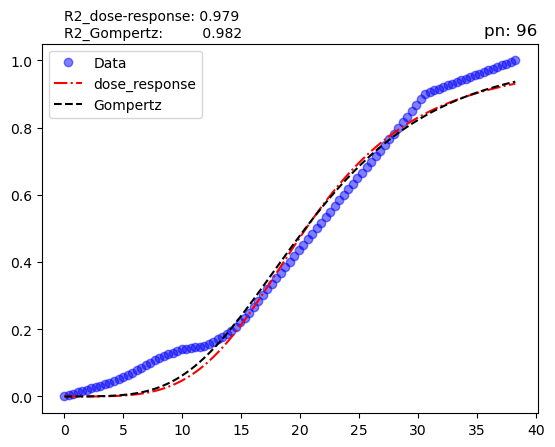

datapoint=  97
no=  90
The optimized parameters for dose-response are: [3.979 3.871]
The optimized parameters for Gompertz are: [1.501 3.306]


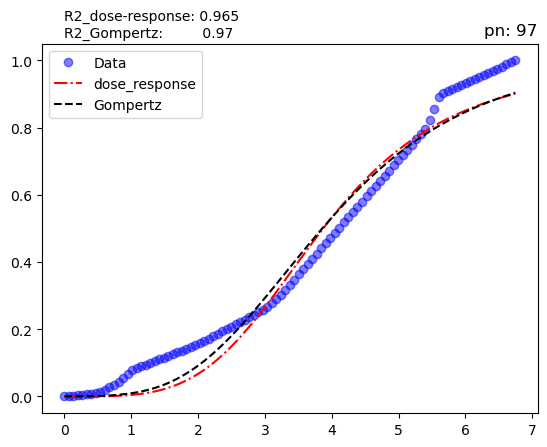

datapoint=  98
no=  91
The optimized parameters for dose-response are: [4.148 3.931]
The optimized parameters for Gompertz are: [1.466 3.372]


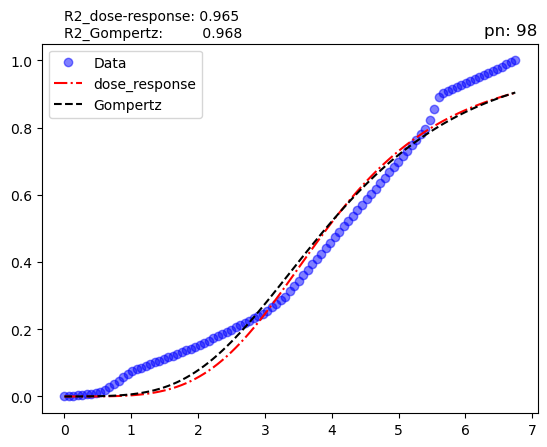

datapoint=  99
no=  92
The optimized parameters for dose-response are: [6.158 4.394]
The optimized parameters for Gompertz are: [1.078 3.961]


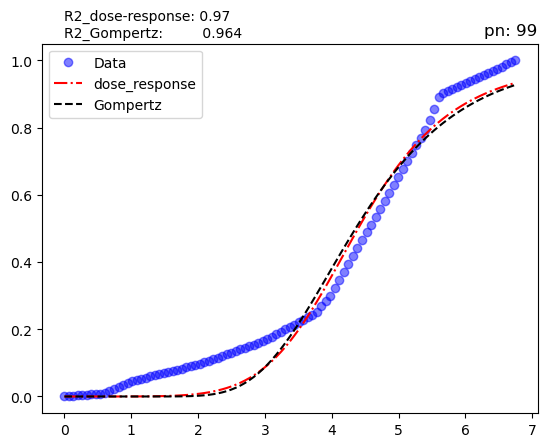

datapoint=  100
no=  93
The optimized parameters for dose-response are: [6.27 4.51]
The optimized parameters for Gompertz are: [1.135 4.038]


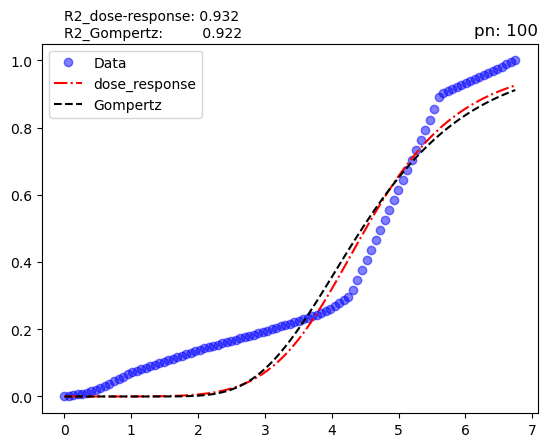

datapoint=  101
no=  94
The optimized parameters for dose-response are: [11.048 17.255]
The optimized parameters for Gompertz are: [ 2.175 16.376]


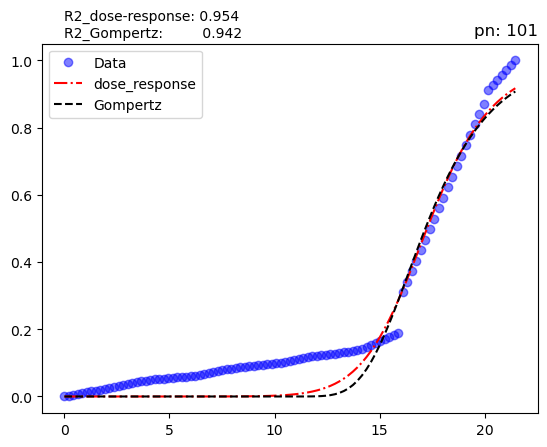

datapoint=  102
no=  95
The optimized parameters for dose-response are: [ 1.686 12.429]
The optimized parameters for Gompertz are: [11.149  9.918]


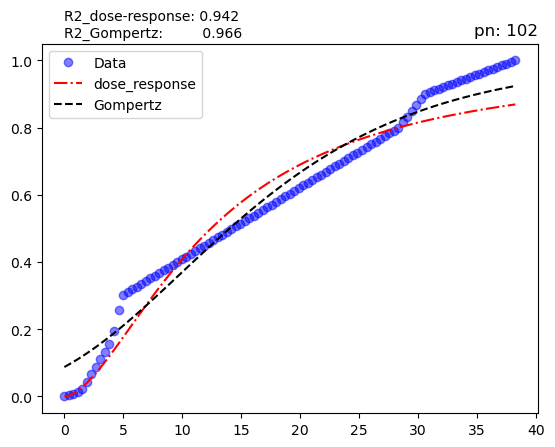

datapoint=  103
no=  96
The optimized parameters for dose-response are: [3.481 3.606]
The optimized parameters for Gompertz are: [1.545 3.063]


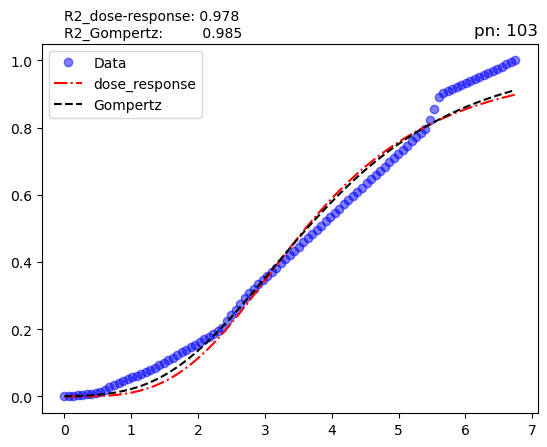

datapoint=  104
no=  97
The optimized parameters for dose-response are: [7.09  4.572]
The optimized parameters for Gompertz are: [0.973 4.173]


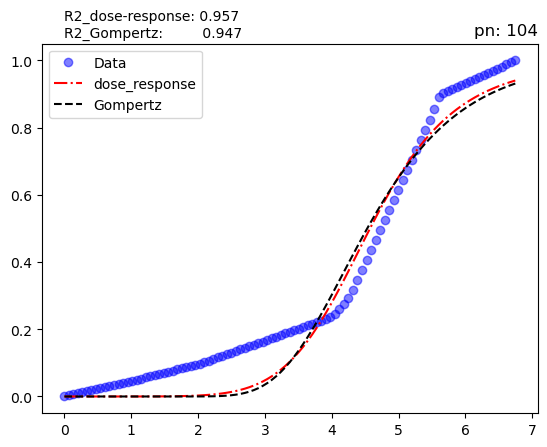

datapoint=  105
no=  98
The optimized parameters for dose-response are: [2.321 3.049]
The optimized parameters for Gompertz are: [1.94  2.459]


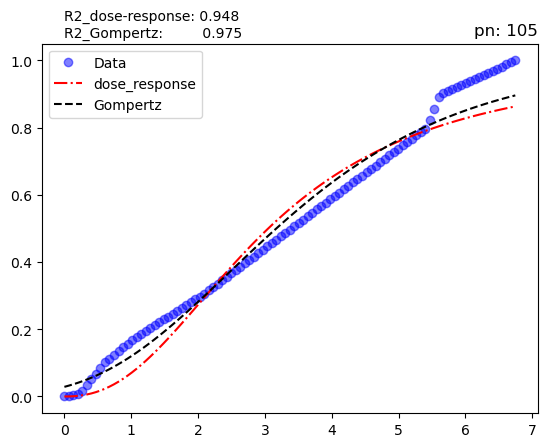

datapoint=  106
no=  99
The optimized parameters for dose-response are: [1.8   1.595]
The optimized parameters for Gompertz are: [1.467 1.265]


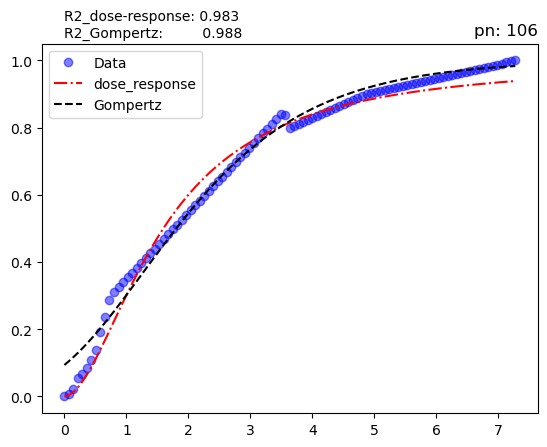

datapoint=  107
no=  100
The optimized parameters for dose-response are: [15.661 19.201]
The optimized parameters for Gompertz are: [ 1.848 18.445]


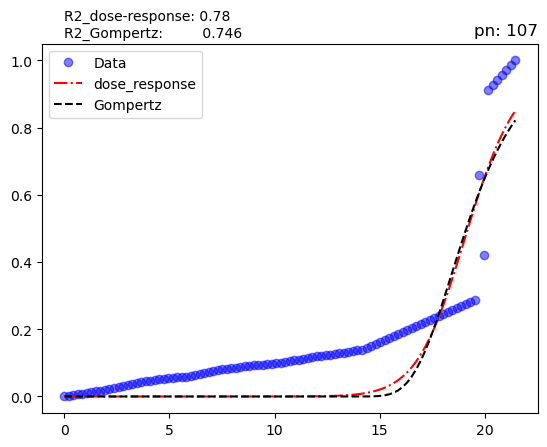

datapoint=  108
no=  101
The optimized parameters for dose-response are: [ 2.201 14.59 ]
The optimized parameters for Gompertz are: [ 9.881 11.887]


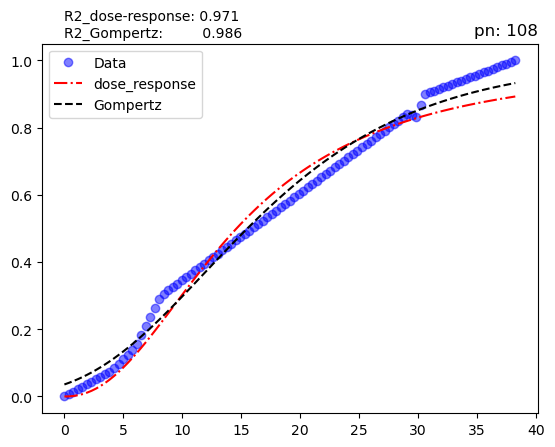

datapoint=  109
no=  102
The optimized parameters for dose-response are: [2.77  3.283]
The optimized parameters for Gompertz are: [1.752 2.715]


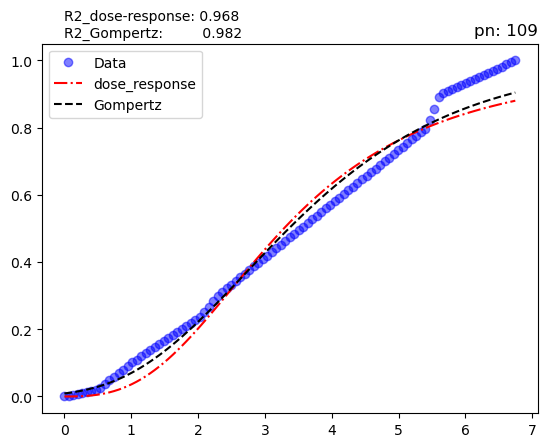

datapoint=  110
no=  103
The optimized parameters for dose-response are: [1.347 1.199]
The optimized parameters for Gompertz are: [1.723 0.839]


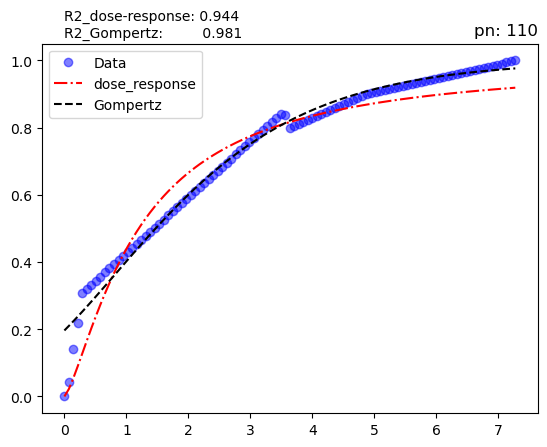

datapoint=  111
no=  104
The optimized parameters for dose-response are: [7.507 4.673]
The optimized parameters for Gompertz are: [0.948 4.278]


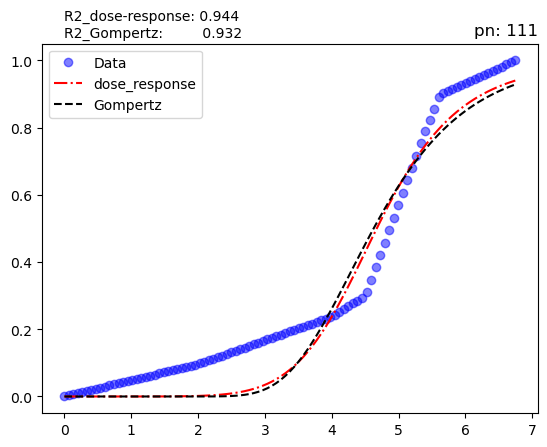

datapoint=  112
no=  105
The optimized parameters for dose-response are: [1.855 1.657]
The optimized parameters for Gompertz are: [1.476 1.306]


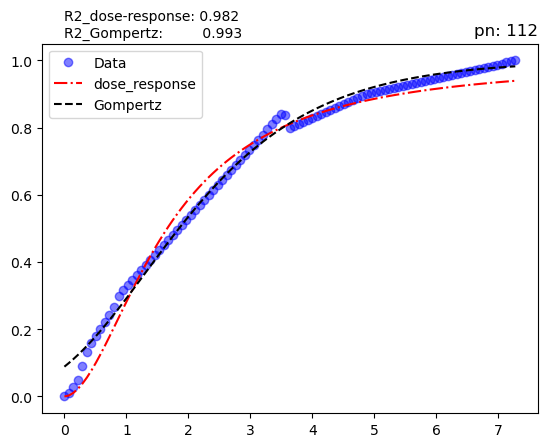

datapoint=  113
no=  106
The optimized parameters for dose-response are: [1.506 0.529]
The optimized parameters for Gompertz are: [0.568 0.411]


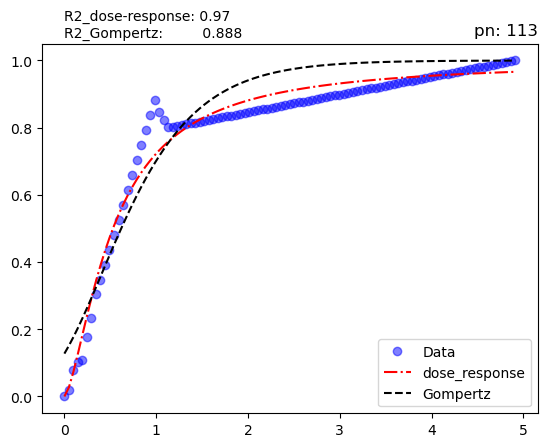

datapoint=  114
no=  107
The optimized parameters for dose-response are: [1.337 0.45 ]
The optimized parameters for Gompertz are: [0.618 0.327]


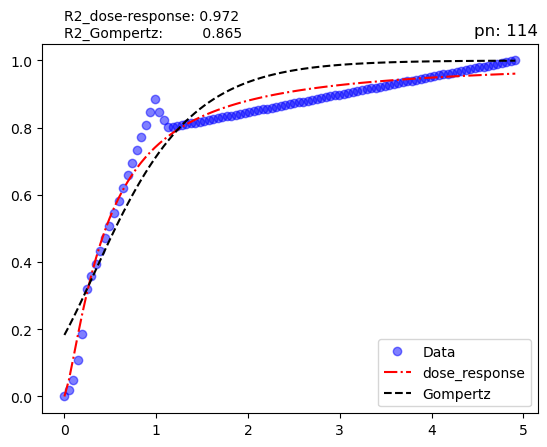

datapoint=  115
no=  109
The optimized parameters for dose-response are: [  6.533 107.281]
The optimized parameters for Gompertz are: [23.781 97.81 ]


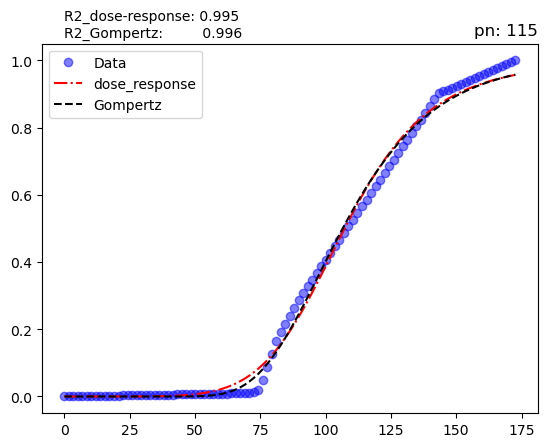

datapoint=  116
no=  111
The optimized parameters for dose-response are: [ 3.402 36.368]
The optimized parameters for Gompertz are: [15.639 31.331]


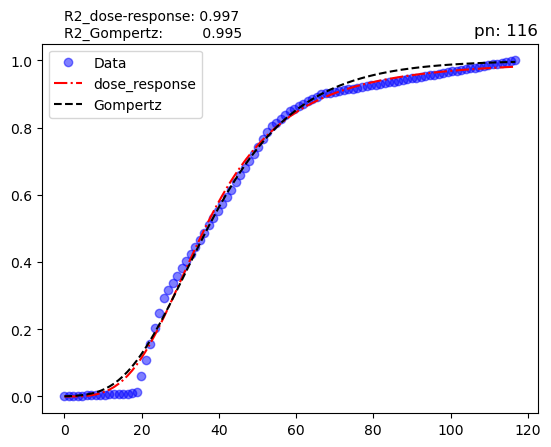

datapoint=  117
no=  112
The optimized parameters for dose-response are: [ 2.831 35.668]
The optimized parameters for Gompertz are: [18.841 30.149]


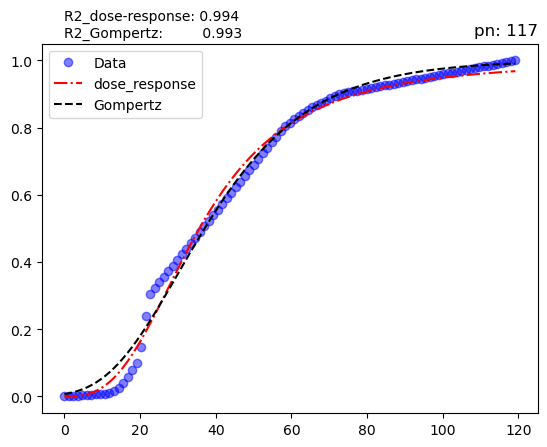

datapoint=  118
no=  113
The optimized parameters for dose-response are: [ 2.85  35.681]
The optimized parameters for Gompertz are: [18.676 30.206]


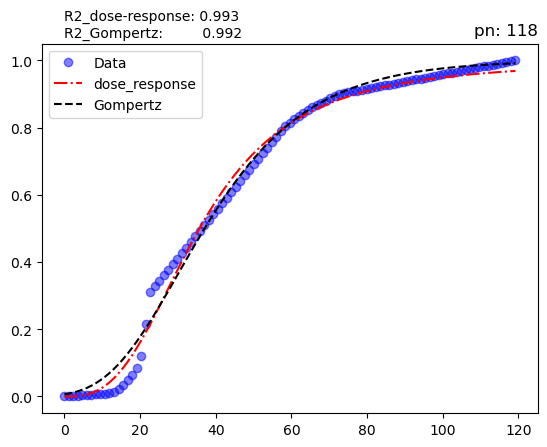

datapoint=  119
no=  114
The optimized parameters for dose-response are: [ 3.839 66.012]
The optimized parameters for Gompertz are: [24.928 57.622]


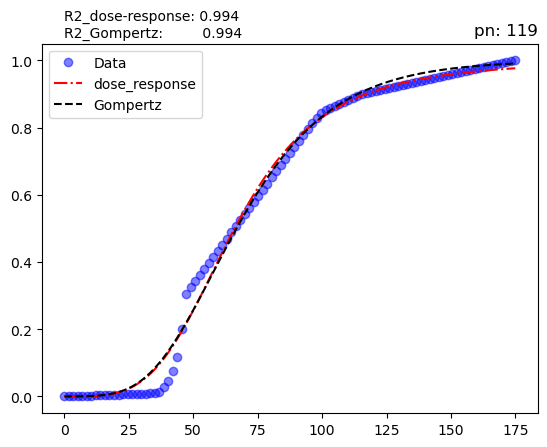

datapoint=  120
no=  115
The optimized parameters for dose-response are: [ 3.404 55.628]
The optimized parameters for Gompertz are: [23.001 48.154]


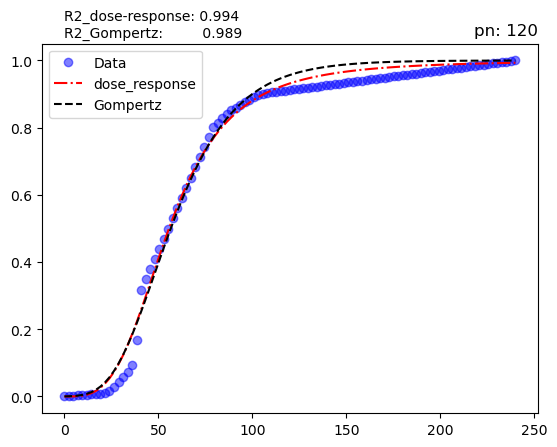

datapoint=  121
no=  116
The optimized parameters for dose-response are: [ 4.236 66.777]
The optimized parameters for Gompertz are: [22.974 58.697]


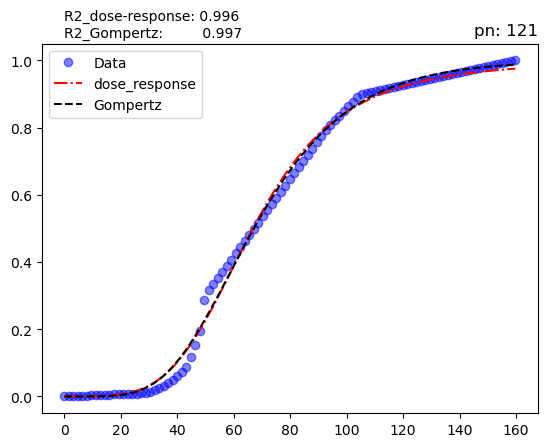

datapoint=  122
no=  117
The optimized parameters for dose-response are: [ 3.701 63.081]
The optimized parameters for Gompertz are: [24.947 54.743]


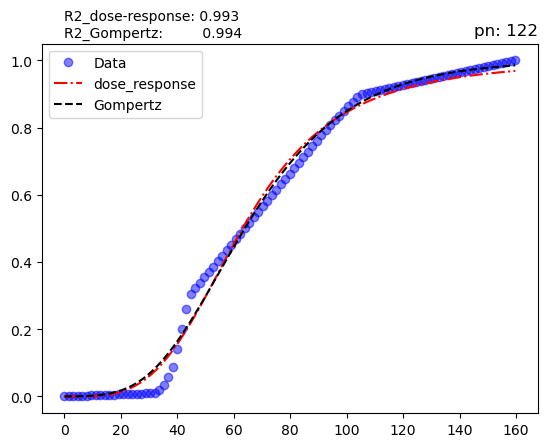

datapoint=  123
no=  118
The optimized parameters for dose-response are: [ 4.849 72.632]
The optimized parameters for Gompertz are: [21.784 64.613]


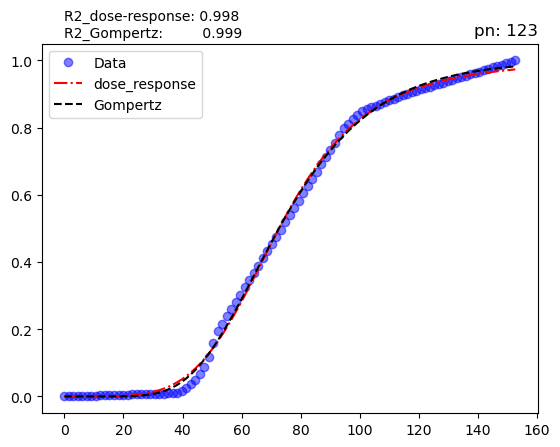

datapoint=  124
no=  119
The optimized parameters for dose-response are: [15.276 90.859]
The optimized parameters for Gompertz are: [ 8.581 87.174]


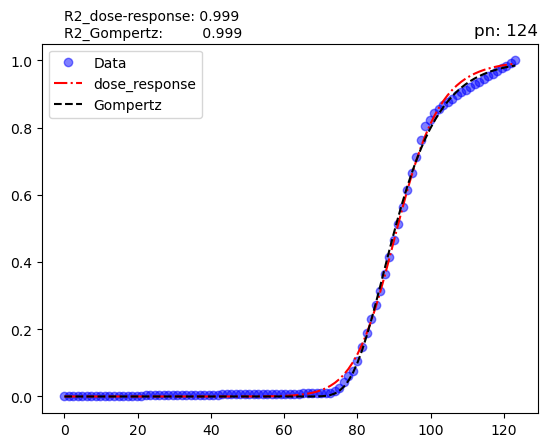

datapoint=  125
no=  120
The optimized parameters for dose-response are: [ 3.255 42.163]
The optimized parameters for Gompertz are: [18.588 36.327]


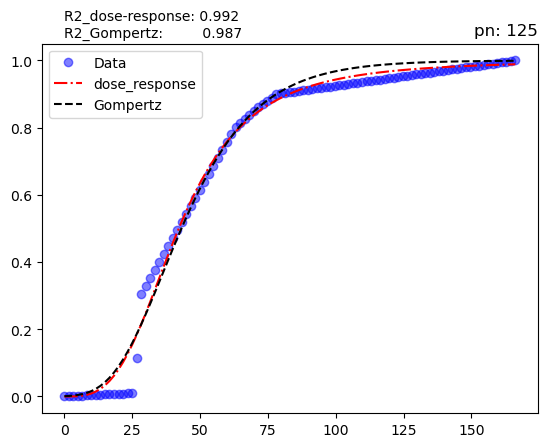

datapoint=  126
no=  121
The optimized parameters for dose-response are: [ 3.261 38.46 ]
The optimized parameters for Gompertz are: [17.392 32.965]


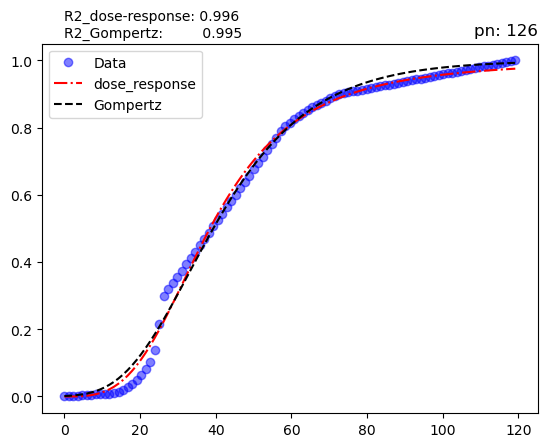

datapoint=  127
no=  122
The optimized parameters for dose-response are: [ 3.812 65.191]
The optimized parameters for Gompertz are: [24.824 56.846]


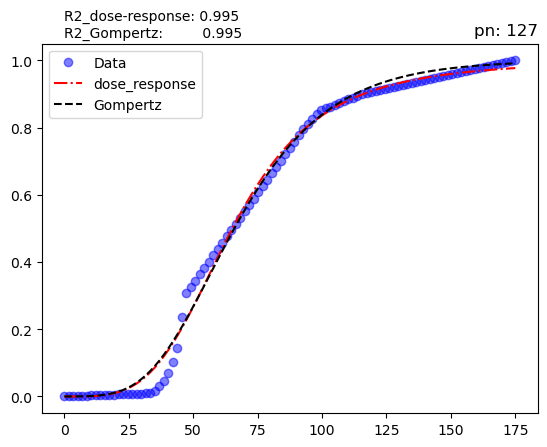

datapoint=  128
no=  123
The optimized parameters for dose-response are: [ 3.549 62.142]
The optimized parameters for Gompertz are: [25.69  53.719]


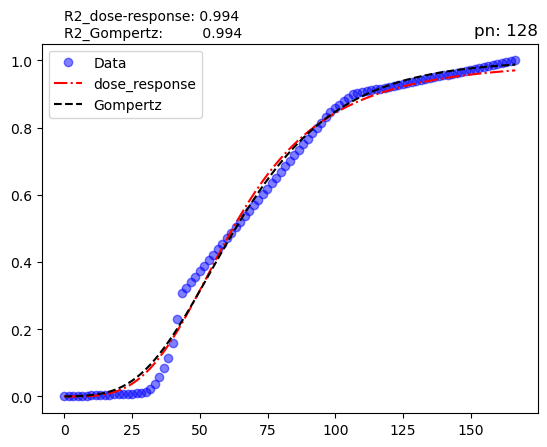

datapoint=  129
no=  124
The optimized parameters for dose-response are: [ 3.961 64.975]
The optimized parameters for Gompertz are: [23.96  56.757]


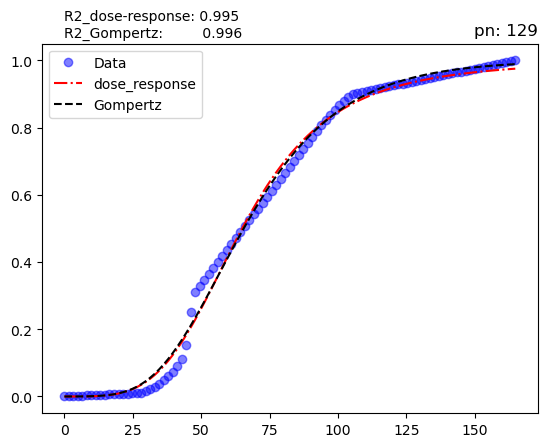

datapoint=  130
no=  125
The optimized parameters for dose-response are: [ 6.278 81.924]
The optimized parameters for Gompertz are: [18.675 74.647]


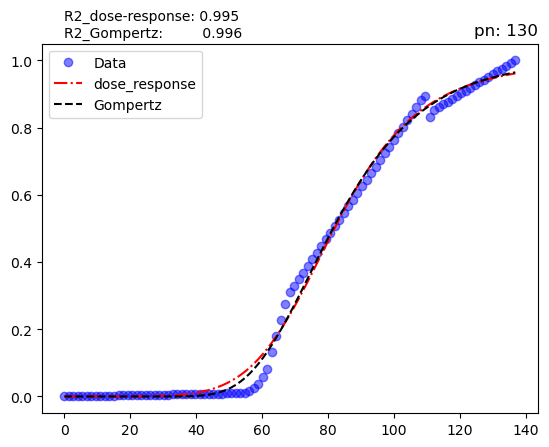

datapoint=  131
no=  126
The optimized parameters for dose-response are: [ 3.508 45.848]
The optimized parameters for Gompertz are: [18.876 39.744]


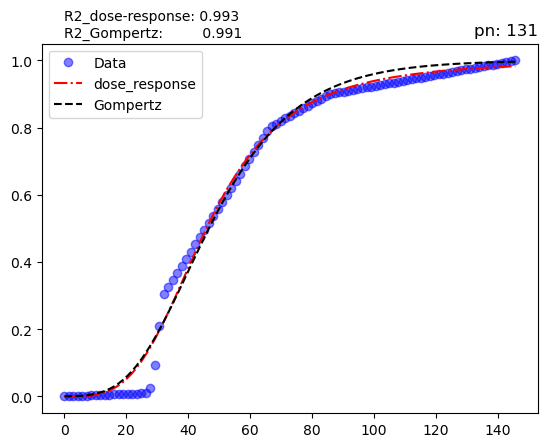

datapoint=  132
no=  127
The optimized parameters for dose-response are: [ 2.809 21.686]
The optimized parameters for Gompertz are: [11.571 18.333]


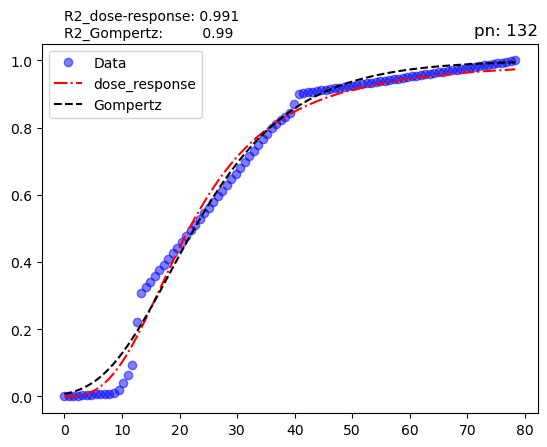

datapoint=  133
no=  128
The optimized parameters for dose-response are: [ 3.939 39.032]
The optimized parameters for Gompertz are: [14.396 34.088]


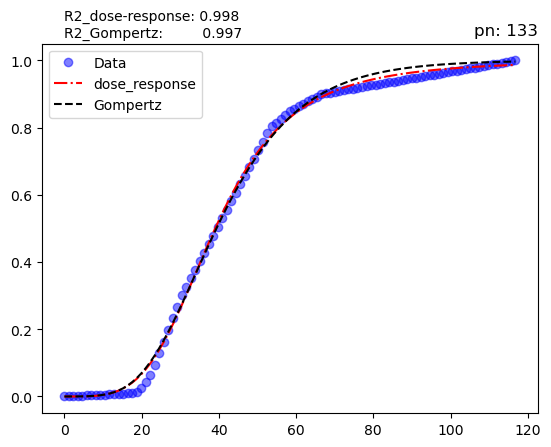

datapoint=  134
no=  129
The optimized parameters for dose-response are: [ 4.124 45.537]
The optimized parameters for Gompertz are: [16.086 39.921]


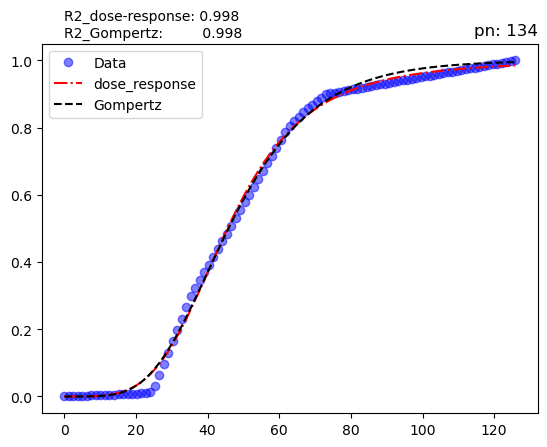

datapoint=  135
no=  130
The optimized parameters for dose-response are: [ 6.68  14.044]
The optimized parameters for Gompertz are: [ 3.053 12.828]


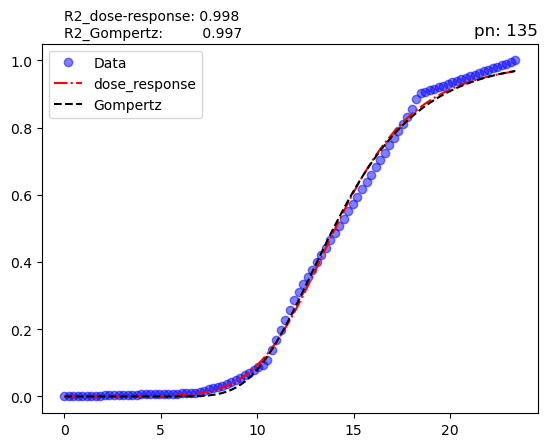

datapoint=  136
no=  131
The optimized parameters for dose-response are: [ 3.949 45.891]
The optimized parameters for Gompertz are: [16.964 40.054]


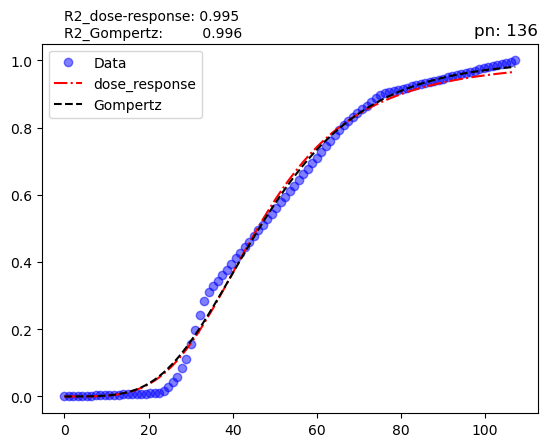

datapoint=  137
no=  132
The optimized parameters for dose-response are: [ 3.949 45.891]
The optimized parameters for Gompertz are: [16.964 40.054]


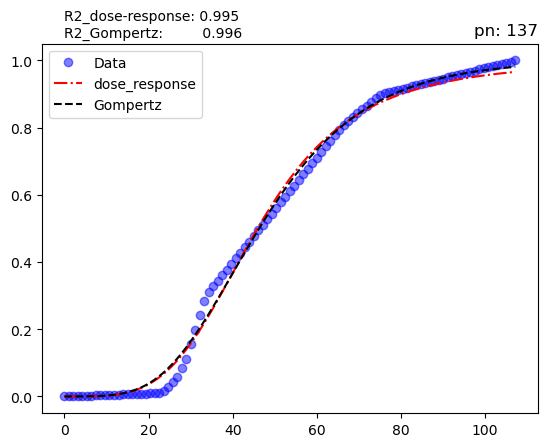

datapoint=  138
no=  133
The optimized parameters for dose-response are: [  8.942 173.737]
The optimized parameters for Gompertz are: [ 28.585 161.825]


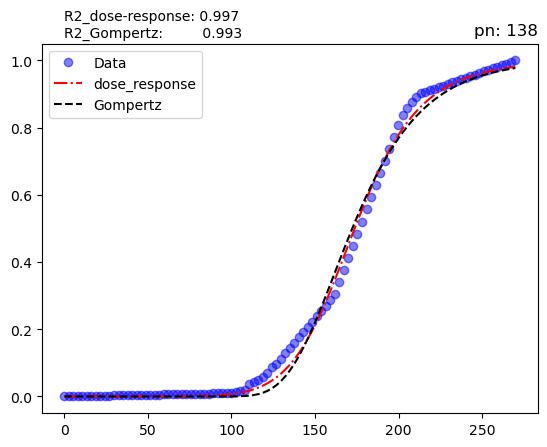

datapoint=  139
no=  134
The optimized parameters for dose-response are: [  8.14  128.814]
The optimized parameters for Gompertz are: [ 22.864 119.427]


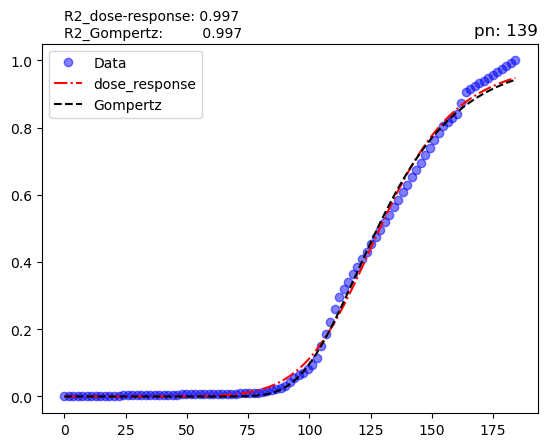

datapoint=  140
no=  135
The optimized parameters for dose-response are: [ 3.948 85.238]
The optimized parameters for Gompertz are: [30.6   74.505]


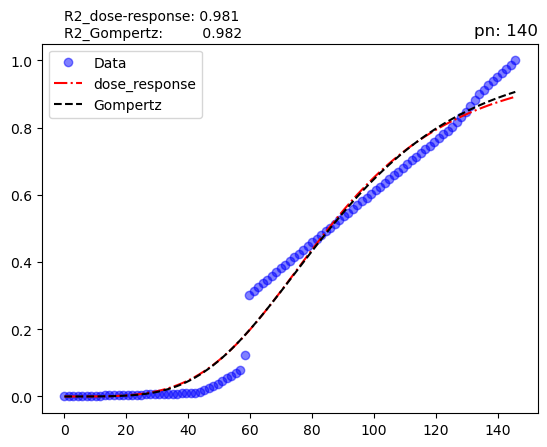

datapoint=  141
no=  142
The optimized parameters for dose-response are: [ 4.279 51.373]
The optimized parameters for Gompertz are: [17.388 45.242]


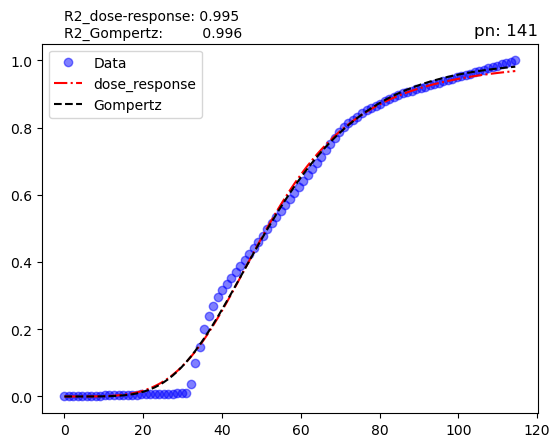

datapoint=  142
no=  143
The optimized parameters for dose-response are: [  5.887 136.198]
The optimized parameters for Gompertz are: [ 33.899 122.961]


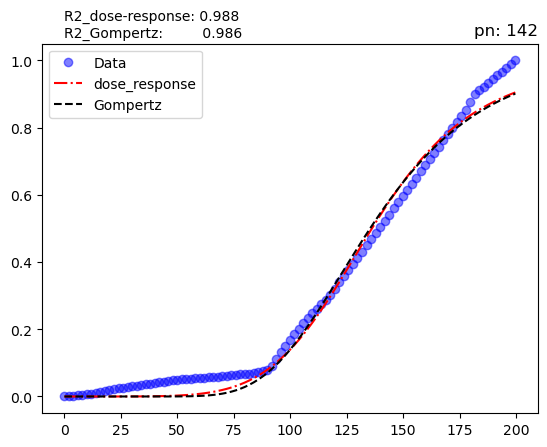

In [140]:

#-------------------------------------------------------------
data={'a': [], 'b':[], 'K': [], 'T':[], 'R2_dose-response': [], 'R2-Gompertz': []}
Coefficent_data = pd.DataFrame(data)
#-------------------------------------------------------------
for i in range(0,143):
    # Define the model equation to fit to the data


    # Generate some sample data
    x_data = np.asanyarray(Final_DF[i]['t'])
    y_data = np.asanyarray(Final_DF[i]['C'])

#---------------------------------------------------------------------
# Define the number of points to interpolate
    num_interp_points = 101

# Create a new array of x values with the desired number of points
    x_interp = np.linspace(x_data.min(), x_data.max(), num=num_interp_points)

# Create an interpolation function for the y values
    interp_func = interp1d(x_data, y_data, kind='linear')

# Interpolate the y values at the new x values
    y_interp = interp_func(x_interp)
#----------------------------------------------------------------------------------

# Fit the model equation to the data
    popt_dr, pcov_dr = curve_fit(dose_response, x_interp, y_interp, bounds=[0,10000], method='trf', p0 =[1,50])
#    popt_clark, pcov_clark = curve_fit(Clark, x_interp, y_interp,  bounds=[0,10000000], method='trf', p0 =[1,0.5])
    popt_gompertz, pcov_gompertz = curve_fit(Gompertz, x_interp, y_interp, bounds=[0,100000000], method='trf', p0 =[1,0.2])
    
    #Calculate the r2 score
    R2_dr= r2_score(y_interp, dose_response(x_interp, *popt_dr))
#    R2_clark= r2_score(y_interp, Clark(x_interp, *popt_clark))
    R2_gompertz= r2_score(y_interp, Gompertz(x_interp, *popt_gompertz))
    
    # Add a new row to the DataFrame
    new_row = {'a': popt_dr[0], 'b': popt_dr[1],
               'K': popt_gompertz[0], 'T': popt_gompertz[1],
              'R2_dose-response': R2_dr,  'R2-Gompertz': R2_gompertz}
    Coefficent_data.loc[len(Coefficent_data)] = new_row
    #Calculate the r2 score
    R2_dr= r2_score(y_interp, dose_response(x_interp, *popt_dr))
#    R2_clark= r2_score(y_interp, Clark(x_interp, *popt_clark))
    R2_gompertz= r2_score(y_interp, Gompertz(x_interp, *popt_gompertz))
    
# Print the optimized parameters
    print('datapoint= ', i)
    print('no= ', sorted_df['no'].iloc[i])
    print(f"The optimized parameters for dose-response are: {popt_dr.round(3)}")
#    print(f"The optimized parameters for clark are: {popt_clark.round(3)}")
    print(f"The optimized parameters for Gompertz are: {popt_gompertz.round(3)}")


# Plot the data and the fitted equation
    plt.plot(x_interp, y_interp, 'bo', label='Data', alpha=0.5)
    plt.plot(x_interp, dose_response(x_interp, *popt_dr), 'r-.', label='dose_response')
#    plt.plot(x_interp, Clark(x_interp, *popt_clark), 'g-', label='Clark') 
    plt.plot(x_interp, Gompertz(x_interp, *popt_gompertz), 'k--', label='Gompertz') 
    plt.text(x_data.max()*0.00, 1.12,  ('R2_dose-response: ' + str(R2_dr.round(3))))
#    plt.text(x_data.max()*0.00,1.15,  ('R2_Clark:                ' + str(R2_clark.round(3))))
    plt.text(x_data.max()*0.00, 1.07,  ('R2_Gompertz:         ' + str(R2_gompertz.round(3))))
    plt.legend()
    plt.title('pn: ' + str(i), loc='right')
    picname= 'Data Fitting/'+str(i) + ' no' +  str(sorted_df['no'].iloc[i]) 
    plt.savefig(picname, dpi=150)
    plt.show()


In [146]:
sorted_df.sort_values(['no'],ignore_index=False)

no feedstock  ref. ref.bio.name  GasTemp  GasRH    O2      N2  \
0      1   camphor    13       SC100B     20.0    0.0   0.0  99.995   
1      2   camphor    13       SC200B     20.0    0.0   0.0  99.995   
2      3   camphor    13       SC300B     20.0    0.0   0.0  99.995   
3      4   camphor    13       SC400B     20.0    0.0   0.0  99.995   
4      5   camphor    13       SC500B     20.0    0.0   0.0  99.995   
..   ...       ...   ...          ...      ...    ...   ...     ...   
72   139    SLUDGE   119          SBG     20.0   40.0  21.0  78.000   
73   140    SLUDGE   119          SLG     20.0   40.0  21.0  78.000   
74   141    SLUDGE   119        SCG-H     20.0   40.0  21.0  78.000   
141  142    SLUDGE   119        SBG-H     20.0   40.0  21.0  78.000   
142  143    SLUDGE   119        SLG-H     20.0   40.0  21.0  78.000   

     H2SConcentration  flowRate  ...  PyrolisTime  P_Method  BiocharRH  \
0                50.0      40.0  ...        300.0         1        0.0   
1                50.0      40.0  ...        300.0         1        0.0   
2                50.0      40.0  ...        300.0         1        0.0   
3                50.0      40.0  ...        300.0         1        0.0   
4                50.0      40.0  ...        300.0         1        0.0   
..                ...       ...  ...          ...       ...        ...   
72            10000.0    2700.0  ...         30.0         1        0.0   
73            10000.0    2700.0  ...         30.0         1        0.0   
74            10000.0    2700.0  ...         30.0         1       90.0   
141           10000.0    2700.0  ...         30.0         1       90.0   
142           10000.0    2700.0  ...         30.0         1       90.0   

     particleSize  S_Weight  Col_d  Col_h  \
0           0.825       1.0   12.0  150.0   
1           0.825       1.0   12.0  150.0   
2           0.825       1.0   12.0  150.0   
3           0.825       1.0   12.0  150.0   
4           0.825       1.0   12.0  150.0   
..            ...       ...    ...    ...   
72          1.000      75.0   32.0  170.0   
73          1.000      85.0   32.0  170.0   
74          1.000      75.0   32.0  170.0   
141         1.000      85.0   32.0  170.0   
142         1.000      75.0   32.0  170.0   

                                                    BC  sort  \
0               t         C
0    0.00000  0.000000
...     0   
1               t         C
0     0.0000  0.000000
...     0   
2               t         C
0     0.0000  0.000000
...     0   
3              t         C
0     0.000  0.000000
1 ...     0   
4               t         C
0     0.0000  0.000000
...     0   
..                                                 ...   ...   
72             t         C
0  0.000000  0.000000
1 ...     0   
73                t         C
0     0.000000  0.000...     0   
74               t         C
0    0.000000  0.00000...     0   
141              t         C
0    0.000000  0.00000...     1   
142               t         C
0     0.000000  0.000...     1   

                                           Modified_BC  
0             t     C
0     0.00  0.00
1    10.09  ...  
1              t     C
0      0.00  0.00
1     40.4...  
2              t     C
0      0.00  0.00
1     88.3...  
3              t     C
0      0.00  0.00
1    399.9...  
4              t     C
0      0.00  0.00
1    151.6...  
..                                                 ...  
72           t     C
0    0.00  0.00
1    0.00  0.0...  
73             t     C
0      0.00  0.00
1     31.1...  
74            t     C
0     0.00  0.00
1     0.06  ...  
141               t     C
0     0.000000  0.00
1   ...  
142               t     C
0     0.000000  0.00
1   ...  

[143 rows x 32 columns]

In [147]:
df=pd.concat([sorted_df, Coefficent_data], axis=1)
df=df.sort_values(['no'],ignore_index=False)
dropp= [47,48,49,50,66,85,95,102,105,110,113,114,74]
for i in dropp:
    df=df[df['no']!=i]


In [150]:
df[['a', 'b', 'K', 'T', 'R2_dose-response', 'R2-Gompertz']].describe().round(3)

a         b        K         T  R2_dose-response  R2-Gompertz
count  130.000   130.000  130.000   130.000           130.000      130.000
mean     7.229   121.148   23.736   112.087             0.979        0.974
std      6.242   207.894   39.244   193.484             0.043        0.052
min      1.046     0.058    0.064     0.048             0.728        0.697
25%      3.707    14.218    2.426    12.815             0.978        0.974
50%      4.932    48.122   15.462    41.072             0.994        0.993
75%      8.284   120.423   23.916   109.663             0.996        0.997
max     44.640  1106.054  240.660  1023.789             0.999        0.999

In [144]:
df.to_pickle("df_coeff.pkl")

In [145]:
df.head(5)

no feedstock  ref. ref.bio.name  GasTemp  GasRH   O2      N2  \
0   1   camphor    13       SC100B     20.0    0.0  0.0  99.995   
1   2   camphor    13       SC200B     20.0    0.0  0.0  99.995   
2   3   camphor    13       SC300B     20.0    0.0  0.0  99.995   
3   4   camphor    13       SC400B     20.0    0.0  0.0  99.995   
4   5   camphor    13       SC500B     20.0    0.0  0.0  99.995   

   H2SConcentration  flowRate  ...  Col_h  \
0              50.0      40.0  ...  150.0   
1              50.0      40.0  ...  150.0   
2              50.0      40.0  ...  150.0   
3              50.0      40.0  ...  150.0   
4              50.0      40.0  ...  150.0   

                                                  BC  sort  \
0             t         C
0    0.00000  0.000000
...     0   
1             t         C
0     0.0000  0.000000
...     0   
2             t         C
0     0.0000  0.000000
...     0   
3            t         C
0     0.000  0.000000
1 ...     0   
4             t         C
0     0.0000  0.000000
...     0   

                                         Modified_BC          a           b  \
0           t     C
0     0.00  0.00
1    10.09  ...   4.193433   29.056448   
1            t     C
0      0.00  0.00
1     40.4...   6.924287  134.811274   
2            t     C
0      0.00  0.00
1     88.3...   9.622541  149.748901   
3            t     C
0      0.00  0.00
1    399.9...  17.551036  513.425181   
4            t     C
0      0.00  0.00
1    151.6...   8.284210  268.698344   

           K           T  R2_dose-response  R2-Gompertz  
0  10.494361   25.183979          0.984019     0.986894  
1  28.650561  123.303715          0.993712     0.990837  
2  21.947262  140.847082          0.994270     0.995882  
3  42.378810  494.556257          0.998871     0.996719  
4  48.022293  249.228841          0.996470     0.992429  

[5 rows x 38 columns]

In [122]:

#-------------------------------------------------------------
data={'a': [], 'b':[], 'K': [], 'T':[], 'R2_dose-response': [], 'R2-Gompertz': []}
Coefficent_data = pd.DataFrame(data)
#-------------------------------------------------------------
for i in range(0,130):
    # Define the model equation to fit to the data


    # Generate some sample data
    x_data = np.asanyarray(df[i]['t'])
    y_data = np.asanyarray(df[i]['C'])

#---------------------------------------------------------------------
# Define the number of points to interpolate
    num_interp_points = 101

# Create a new array of x values with the desired number of points
    x_interp = np.linspace(x_data.min(), x_data.max(), num=num_interp_points)

# Create an interpolation function for the y values
    interp_func = interp1d(x_data, y_data, kind='linear')

# Interpolate the y values at the new x values
    y_interp = interp_func(x_interp)
#----------------------------------------------------------------------------------

# Fit the model equation to the data
    popt_dr, pcov_dr = curve_fit(dose_response, x_interp, y_interp, bounds=[0,10000], method='trf', p0 =[1,50])
#    popt_clark, pcov_clark = curve_fit(Clark, x_interp, y_interp,  bounds=[0,10000000], method='trf', p0 =[1,0.5])
    popt_gompertz, pcov_gompertz = curve_fit(Gompertz, x_interp, y_interp, bounds=[0,100000000], method='trf', p0 =[1,0.2])
    
    #Calculate the r2 score
    R2_dr= r2_score(y_interp, dose_response(x_interp, *popt_dr))
#    R2_clark= r2_score(y_interp, Clark(x_interp, *popt_clark))
    R2_gompertz= r2_score(y_interp, Gompertz(x_interp, *popt_gompertz))
    
    # Add a new row to the DataFrame
    new_row = {'a': popt_dr[0], 'b': popt_dr[1],
               'K': popt_gompertz[0], 'T': popt_gompertz[1],
              'R2_dose-response': R2_dr,  'R2-Gompertz': R2_gompertz}
    Coefficent_data.loc[len(Coefficent_data)] = new_row
    #Calculate the r2 score
    R2_dr= r2_score(y_interp, dose_response(x_interp, *popt_dr))
#    R2_clark= r2_score(y_interp, Clark(x_interp, *popt_clark))
    R2_gompertz= r2_score(y_interp, Gompertz(x_interp, *popt_gompertz))
    
# Print the optimized parameters
    print('datapoint= ', i)
    print('no= ', sorted_df['no'].iloc[i])
    print(f"The optimized parameters for dose-response are: {popt_dr.round(3)}")
#    print(f"The optimized parameters for clark are: {popt_clark.round(3)}")
    print(f"The optimized parameters for Gompertz are: {popt_gompertz.round(3)}")


# Plot the data and the fitted equation
    plt.plot(x_interp, y_interp, 'bo', label='Data', alpha=0.5)
    plt.plot(x_interp, dose_response(x_interp, *popt_dr), 'r-.', label='dose_response')
#    plt.plot(x_interp, Clark(x_interp, *popt_clark), 'g-', label='Clark') 
    plt.plot(x_interp, Gompertz(x_interp, *popt_gompertz), 'k--', label='Gompertz') 
    plt.text(x_data.max()*0.00, 1.12,  ('R2_dose-response: ' + str(R2_dr.round(3))))
#    plt.text(x_data.max()*0.00,1.15,  ('R2_Clark:                ' + str(R2_clark.round(3))))
    plt.text(x_data.max()*0.00, 1.07,  ('R2_Gompertz:         ' + str(R2_gompertz.round(3))))
    plt.legend()
    picname= 'Data Fitting/'+str(sorted_df['no'].iloc[i]) + ' no' + str(i)
    plt.savefig(picname, dpi=50)
    plt.show()

KeyError: 0